<a href="https://colab.research.google.com/github/eitanfass/Tomato_quality/blob/main/main_code_tomato_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing and installing libraries


In [ ]:
#@title
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#@title
!pip install spectral

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 212 kB 9.4 MB/s 


In [ ]:
#@title
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
import numpy as np
import seaborn as sns
import random
import torch
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from google.colab import drive
drive.mount('/content/drive')
# from sklearn import preprocessing
from sklearn.metrics import pairwise_distances_argmin,mean_squared_error,silhouette_score,r2_score

import pylab as pl
from sklearn import datasets, linear_model

from sklearn.preprocessing import StandardScaler
from scipy import stats
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
%matplotlib inline
from spectral import *
from skimage import io,measure, img_as_ubyte
import cv2
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage import io
from scipy import ndimage as nd
'''
The imutils library is a series of convenience functions to make basic image processing functions such as translation,
rotation, resizing, skeletonization, and displaying Matplotlib images easier with OpenCV and Python 3.'''
import imutils
import os
import datetime
    


Mounted at /content/drive


#Creating classes:

TODO to sync the old functions with the find color function.

In [ ]:
global_band_table = pd.read_csv('/content/drive/MyDrive/Shared_tomato/Eitan/chennel chart.csv')
global wave_band_table,band_depth,R_wave,G_wave,B_wave
wave_band_table=np.array(global_band_table.loc[:,global_band_table.columns[-1]])
band_depth,R_wave,G_wave,B_wave=204,80,45,20
class Harvest():

    def __init__(self, tomato_shape, lab_results_path,reflectence_path):
      
      self.tomato_shape=tomato_shape# tomato shape: round, roma, cherry...
      self.lab_results=pd.read_csv(lab_results_path)#read lab results from folder
      self.cultivar,self.harvest_date=self._get_id()
      self.reflectence=pd.read_csv(reflectence_path)#read reflectence from folder
      self.reflectence=self.reflectence.drop([self.reflectence.columns[0]],axis=1)
      self.reflectence=self.reflectence.T

    def _get_id(self):#gets a lab results df and from id column reads cultivar and harvest date
      self.cultivar=self.lab_results.iloc[0][0].split('_')[0]
      self.harvest_date=self.lab_results.iloc[0][0].split('_')[1:4]
      return self.cultivar,self.harvest_date




class TomatoImage():# still needs work, in planning to have it read tomato images and segment it to indevidual sample
  
  def __init__(self,img_path, mask_path, bands_to_wave_table ,metadata=None,mask=None):
    self._load_img(img_path)#create spectral and RGB images
    self.mask=self.load_mask(mask_path)#TODO loads a mask or creats one from img
    self.bands_to_waves= bands_to_wave_table
    self.metadata=metadata#img matadata (optional)
  
  def spectral_to_RGB(self, img):
    global R_wave,G_wave,B_wave
    self.RGB=np.zeros([img.shape[0],img.shape[0],3],dtype=float)# create tamplate for RGB

    #normalize pixel value to have max valiue of 1 an min value of 0 for each layer
    self.RGB[:,:,0]=(img[:,:,R_wave]-img[:,:,R_wave].min())/(img[:,:,R_wave].max()-img[:,:,R_wave].min())#red 
    self.RGB[:,:,1]=(img[:,:,G_wave]-img[:,:,G_wave].min())/(img[:,:,G_wave].max()-img[:,:,G_wave].min())#green
    self.RGB[:,:,2]=(img[:,:,B_wave]-img[:,:,B_wave].min())/(img[:,:,B_wave].max()-img[:,:,B_wave].min())#blue
    #TODO add save as jpeg
    return self.RGB
  
  def _load_img(self,img_path):#function that loads image using spectral library
    img = open_image(img_path)
    self.spectral=np.array(img.load())#read as np.array dims=[512,512,204](for specim iq images)
    self.spectral=np.rot90(self.spectral[:,:,:],3)#rotate (optional)
    self.RGB = self.spectral_to_RGB(self.spectral)#save an RGB vesion of the image


  def load_mask(self, mask_path):
    pass
  
class Tomato():
  '''tomato object holds tomato instences
   with all of their information, usful for
    looking at individul samples'''
  def __init__(self,lab_results,harvest:Harvest,tomato_id:int, reflectence,tomato_img=None):
      self.reflectence=reflectence
      self.lab_results=lab_results
      self.tomato_id=self.lab_results.iloc[0]
      self.harvest_date=harvest.harvest_date
      self.cultivar=harvest.cultivar
      if tomato_img==None:
        pass
      self.tomato_img=tomato_img
  def update_ref(self, reflectence):
      pass


class TomatoList():
  ''' gets a harvest list and preduces all
   tyoes of analitical and graphing functions
    on the tomato data within the harvet list '''

  def __init__(self,harvest_list,tomato_img=None ,poligon_file=None ,):
    self.tomato_img=tomato_img
    self.harvest_list=harvest_list
    self.poligon_file=poligon_file
    self.tomato_dict=self._harvest_list_to_tomato_dict()
    self.tomato_list=self.creat_tomato_list(self.tomato_dict)
    self._harvest_list_to_df()
    self.cultivar_list=set([i.cultivar for i in self.harvest_list])
    self.harvest_date_list=self._get_harvest_dates()
    self.get_date_str()
  def _get_harvest_dates(self):
    format = '%Y-%m-%d'
    harvest_dates=[datetime.datetime.strptime(f'{i.harvest_date[2]}-{i.harvest_date[1]}-{i.harvest_date[0]}', format).date() for i in self.harvest_list]
    harvest_dates.sort()
    return harvest_dates
  def creat_tomato_list(self,tomato_dict):
    return [tomato_dict[i] for i in range(1,len(tomato_dict.keys())+1)]
  def _harvest_list_to_tomato_dict(self)->dict:
    tomato_dict={}
    key_count=1
    for i in self.harvest_list:
      temp=create_Tomato_instances(i)
      for j in range (key_count,(key_count+len(temp.keys()))):
        tomato_dict[j]=temp[j-key_count]
      key_count+=len(temp.keys())
    return tomato_dict
  def _harvest_list_to_df(self)->pd.DataFrame():
    global band_depth
    count=1
    all_tomatoes=pd.DataFrame()
    for i in self.harvest_list:
      new_index=np.arange(count,count+i.lab_results.shape[0])
      i.reflectence=i.reflectence.set_index(new_index)
      i.lab_results=i.lab_results.set_index(new_index)
      reflecttence_lab_results_df=pd.concat([i.reflectence,i.lab_results],axis=1)
      all_tomatoes=pd.concat([all_tomatoes,reflecttence_lab_results_df],axis=0)
      count+=i.lab_results.shape[0]
    self.tomato_df=all_tomatoes
    self.lab_results_df=all_tomatoes.loc[:,'Weight (g)':]
    self.np_reflectence=np.array(all_tomatoes.loc[:,:(band_depth-1)])
    self.reflectence_df=all_tomatoes.loc[:,:(band_depth-1)]
    
  def get_date_str(self):
    date_list=[i.strftime("%m-%d-%Y") for i in self.harvest_date_list ]
    self.date_str=''
    for i in date_list:
      self.date_str+=f'{i}_'
  def get_color_maps(self,stat_key_list:list=[1,2,3,4],plot=True):#{1:'$R^2$',2:'R',3:'RMSE',4:'Spearsman corrolation'} enter the key numbers of stats to get maps for
    folder_path='/content/drive/MyDrive/Shared_tomato/Eitan/colormaps'
    waves=[float(i) for i in global_band_table['wavelangth'] ]
    columns=self.lab_results_df.columns
    to_save=True
    self.rmse_dict,self.R_dict,self.r_2_dict,self.spearsman_dict={},{},{},{}
    stats={'RMSE':self.rmse_dict,'R':self.R_dict,'R_2':self.r_2_dict,'spearsman_corrolation':self.spearsman_dict}
    for stat_name,map_dict in stats.items():
      for col in columns:
        if os.path.exists(f"{folder_path}/{self.date_str}{stat_name}_map_{col.replace('/',':')}.csv"):
          to_save=False
          #upload maps from storage
          map_dict[col]=np.array(pd.read_csv(f"{folder_path}/{self.date_str}{stat_name}_map_{col.replace('/',':')}.csv"))
          map_dict[col]=map_dict[col][:,1:]
    if to_save==True:
      self.r_2_dict,self.R_dict,self.rmse_dict,self.spearsman_dict=plot_NI_colormaps(self)#run NI model
      plot_colormaps(self,stat_key_list)#plot colormaps
      stats={'RMSE':self.rmse_dict,'R':self.R_dict,'R_2':self.r_2_dict,'spearsman_corrolation':self.spearsman_dict}
      #save colormap results
      for stat_name,map_dict in stats.items():
        for col,map in map_dict.items():    
          temp_df=pd.DataFrame(map,columns=waves,index=waves)
          temp_df.to_csv(f"{folder_path}/{self.date_str}{stat_name}_map_{col.replace('/',':')}.csv")#save
    else: plot_colormaps(self,stat_key_list)
      
class TomatoFromImage():
    def __init__(self, harvest:Harvest,tomato_id, tomato_imgs, lab_results_path:str, reflectence:pd.DataFrame=None):
      self.reflectence=reflectence
      self.lab_results=pd.read_csv(self.lab_results_path)
      self.tomato_imgs=tomato_imgs
      self.harvest=harvest

      self.tomato_id=tomato_id

    def update_ref(self, reflectence):
      pass


#functions

In [ ]:
def calc_stats_per_band(tomato_img):
  np_image_array = tomato_img.img
  band_depth=np_image_array.shape[2]
  stats={}
  mask=tomato_img.mask.flatten()
  for i in range(band_depth):
    flat=np_image_array[:,:,i].flatten()
    filterd = flat * mask
    filterd[mask==0]=None
    stats[i]= (flat.min(), flat.max() ,flat.mean() , np.median(flat) ,flat.std())
  return stats

def create_Tomato_instances(harvest:Harvest)->dict:
  '''function that gest a harvest
   object and creates tomato instences 
   in a dictionery with the key value the id'''
  T={}
  for i in range(harvest.lab_results.shape[0]):
    T[i]=Tomato(harvest.lab_results.iloc[i],harvest,i, harvest.reflectence.iloc[i])
  return T

def NI_loop(tomato_list, col:str):
  ''' input TomatoList obj, 
  returns r_2,rmse colormaps dict 
  with lab result parametrs as keys '''
  
  global band_depth
  r_2 = np.arange(band_depth*band_depth).reshape(band_depth, band_depth)
  r_2=np.float32(r_2)
  rmse =r_2.copy()
  spear=r_2.copy()
  R=r_2.copy()
  temp_df=pd.concat([tomato_list.reflectence_df,tomato_list.lab_results_df[col]],axis=1)
  temp_df=temp_df[temp_df[col]>0].dropna(axis=0)
  np_results=np.array(temp_df[col])
  np_reflectence=np.array(temp_df.loc[:,:(band_depth-1)])
  for j in range(band_depth):#running all combinations
    for y in range(band_depth):
      NI=(np_reflectence[:,y]-np_reflectence[:,j])/(np_reflectence[:,y]+np_reflectence[:,j])
      slope, intercept, R[y,j], p_value, std_err = stats.linregress(NI,np_results) 
      r_2[y,j] =  R[y,j]**2
      rmse[y,j] =np.sqrt(((np_results-(intercept + (slope *NI)))**2).mean())
      spear[y,j],p_val= stats.spearmanr(NI, b=np_results)
  return r_2,R,rmse,spear

  
def plot_NI_colormaps(tomato_list):#),stat_key_list,plot):#{1:'$R^2$',2:'R',3:'RMSE',4:'Spearsman corrolation'} stats to dispaly
  global global_band_table
  waves=[float(i) for i in global_band_table['wavelangth'] ]
  colormaps=[cm.get_cmap('viridis', 256)]
  r_2_dict,R_dict, rmse_dict,spear_dict={},{},{},{}
  stat_dict={1:'$R^2$',2:'R',3:'RMSE',4:'Spearsman corrolation'}
  
  for col in tomato_list.lab_results_df.columns:
    r_2,R,rmse,spear=NI_loop(tomato_list, col)
    r_2_dict[col],R_dict[col], rmse_dict[col],spear_dict[col]=r_2,R,rmse,spear
  return r_2_dict,R_dict, rmse_dict,spear_dict

def plot_all_reflectence(tomato_list):# plots all reflectence data in the above format, wave df is requaired
  global global_band_table,band_depth
  fig, ax = plt.subplots(figsize=(10,7))
  df=tomato_list.reflectence_df.T
  x=list(np.arange(0,band_depth,50,dtype=int))
  for i in df.columns:
    ax.plot(df[i])
    plt.axvline(x=23,color='b',lw=5)
    plt.axvline(x=47,color='g',lw=5)
    plt.axvline(x=80,color='r',lw=5)
  ax.set(xlabel='Wavelangth (nm)',
        ylabel='Reflectence'
        )
  plt.xticks(ticks=x, labels =global_band_table.loc[x]['wavelangth']//10*10)


def max_bands_from_colormaps(map_dict:dict,number_of_max_values=3)->dict:
  '''function thar receives a colormap
   and the number of max value and finds
    the band combination for them'''
  bands={}
  for k,v in map_dict.items():
    for i in range(1,number_of_max_values+1):
      bands[f'{k}-max {i}']= np.unravel_index(map.argmax(), map.shape)
      map[bands[f'{k}-max {i}'][0],bands[f'{k}-max {i}'][1]]=0
  return bands

def regretionplot(tomato_list,red_index=False, number_of_max_values=1):
  '''creats a regretssion plot,
   colors the samples by their red index values from green to red,
    data_dict in format of add_res_to_ref function'''
  R_2_map_dict=tomato_list.r_2_dict
  global global_band_table,R_wave,G_wave,band_depth
  if red_index:
    b1,b2=R_wave,G_wave
    number_of_max_values=1
  else:bands=max_bands_from_colormaps(R_2_map_dict,number_of_max_values)
  waves=[float(i) for i in global_band_table['wavelangth'] ]
  palette = {1:"lime",2:"orange",3:"tomato",4:"red"}#,2:"orangered",4:"darkorange",6:"gold"
  for col in tomato_list.tomato_df.loc[:,'Weight (g)':].columns:#loop on the columns names of results
    temp_df=pd.concat([tomato_list.tomato_df.loc[:,:(band_depth-1)],tomato_list.tomato_df[col]],axis=1)
    temp_df=temp_df[temp_df[col]>0].dropna(axis=0)
    np_results=np.array(temp_df[col])# created a clean np array of results with no nan None or negetive values
    np_reflectence=np.array(temp_df.loc[:,:(band_depth-1)])
    for i in range(1,number_of_max_values+1):
      if R_2_map_dict!=None:
        b1,b2=bands[f'{col}-max {i}']
      NI=((np_reflectence[:,b1]-np_reflectence[:,b2])/(np_reflectence[:,b1]+np_reflectence[:,b2]))
      red_index=(np_reflectence[:,R_wave]-np_reflectence[:,G_wave])/(np_reflectence[:,R_wave]+np_reflectence[:,G_wave])#getting a red index value for all samples
      color=red_index-red_index.min()
      num=(color.max()/4)+0.00001
      color=(color//num)+1#color of all samples in pallette keys as colors
      x_tag=  'NI'
      data_dict={x_tag:NI ,col:np_results, 'Color':color}
      data=pd.DataFrame(data_dict)
      slope, intercept, r_value, p_value, std_err = stats.linregress(data[x_tag],data[col])
      sns.lmplot(x=x_tag, y=col, hue="Color", data=data,palette=palette, fit_reg=False, legend=False)#x_estimator=np.mean
      plt.rcParams.update({'figure.figsize':(20,15), 'figure.dpi':100})
      ax = sns.regplot(x=x_tag , y=col, data=data, scatter_kws={"zorder":-1}, line_kws={'color': 'black','label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
      ax.text(0.18, 1.05, "R=: {:.2f}   P-value= {:.4f} ".format(r_value,p_value), ha="left", va="top",fontsize=15, transform=ax.transAxes)
      ax.text(0.20, 1, "bands=({:.0f}nm,{:.0f}nm)".format(waves[b1],waves[b2]), ha="left", va="top",fontsize=15, transform=ax.transAxes)
    # plt.legend(bbox_to_anchor=(1.15, 1), loc=2, borderaxespad=0.)
def get_color_groups(tomato_list,color_groups:int=3)->pd.DataFrame():# helper function to get color groups for plotting
  global band_depth,R_wave,G_wave
  np_ref=np.array(tomato_list.tomato_df.loc[:,:(band_depth-1)])
  l=(np_ref[:,R_wave]-np_ref[:,G_wave])/(np_ref[:,R_wave]+np_ref[:,G_wave])
  ref_new=tomato_list.tomato_df.loc[:,:(band_depth-1)]
  ref_new['Red Index']=l
  l1=l-l.min()
  lab_results=tomato_list.tomato_df.loc[:,'Weight (g)':]
  lab_results['Red Index']=l1
  num=(l1.max()/color_groups)+0.00001
  l1=(l1//num)+1
  lab_results['sample']=range(np_ref.shape[0])
  sorted_by_color=lab_results.sort_values(by=['Red Index'])
  sorted_by_color['color']=range(np_ref.shape[0])
  sorted_by_color['color']=sorted_by_color['color']//(np_ref.shape[0]/color_groups)+1
  final_df=sorted_by_color.sort_values(by=['sample'])
  final_df=final_df.drop(['Red Index','sample'],axis=1)
  return final_df

def plot_colormaps(tomato_list,stat_key_list,save_to_path='/content/drive/MyDrive/Shared_tomato/Eitan/plots/'):#{1:'$R^2$',2:'R',3:'RMSE',4:'Spearsman corrolation'} stats to dispaly
  global global_band_table
  stat_name_dict={1:'$R^2$',2:'R',3:'RMSE',4:'Spearsman corrolation'}
  stat_dict={1:tomato_list.r_2_dict,2:tomato_list.R_dict,3:tomato_list.rmse_dict,4:tomato_list.spearsman_dict}
  waves=[float(i) for i in global_band_table['wavelangth'] ]
  colormaps=[cm.get_cmap('viridis', 256)]
  for stat_name,map_dict in zip(stat_name_dict.items(),stat_dict.items()):
    if stat_name[0] in stat_key_list:
      for col,map in map_dict[1].items():
        data = pd.DataFrame(data=map,index=waves,columns=waves)
        n = len(colormaps)
        mask =  np.tri(data.shape[0], k=-1)
        data= np.ma.array(data, mask=mask)
        fig, axs = plt.subplots(1,n, figsize=(10, 10),
                    constrained_layout=False, squeeze=False)
        for [ax, cmap] in zip(axs.flat, colormaps):   
            psm = ax.pcolormesh(waves,waves,data, cmap=cmap, rasterized=True, vmin=data[~np.isnan(data)].min(), vmax=data[~np.isnan(data)].max())
            fig.colorbar(psm, ax=ax)
        plt.title(f'{stat_name[1]} of normalized index with {col}')
        plt.xlabel('Band 1 (nm)')
        plt.ylabel('Band 2 (nm)')
        plt.show()
        path_col=col.replace('/',':')
        plt.savefig(f'{save_to_path}{tomato_list.date_str}colormap_plot_{stat_name[1]}_with_{path_col}.png')



In [ ]:
def histogram_by_color(tomato_list,col,color_grups=3
                       ,palette=['lime','orange','r'],
                       save_to_path='/content/drive/MyDrive/Shared_tomato/Eitan/plots/'):# TODO make a few paletts for user to call optinal
  
  if color_grups!=len(palette):
    print('palette and color groups must match')
    return
  data=get_color_groups(tomato_list,color_grups)
  data=data[data[col]>0]
  start=data[col].min()
  end=data[col].max()
  step=(end-start)/10
  fig, ax = plt.subplots(1,  figsize=(10,7))
  for i,c in zip(range(color_grups),palette):
    
    bins=np.arange(start,end+step,step)
    start+=step/color_grups
    end+=step/color_grups
    c_grup=data[col][data['color']==(i+1)]
    ax.hist(c_grup,color=c,label=f"n={len(c_grup)} STD={c_grup.std():.2f} Mean={c_grup.mean():.1f}" ,bins=bins,width=step/color_grups)
  ax.set_xlabel(col, fontsize = 20)
  ax.set_ylabel('number of samples', fontsize = 20)
  ax.set_title(f'groups 1-{color_grups} {col} distrubution\n N={len(data[col])} STD={data[col].std():.2f} Mean={data[col].mean():.1f}', fontsize = 25)
  ax.legend(fontsize=15)
  path_col=col.replace('/',':')
  plt.savefig(f'{save_to_path}{tomato_list.date_str}_linear_hist_{path_col}_N={len(data[col])}')
def category_histograms(tomato_list,col,categories=5,
                        color_grups=3,palette=['lime','orange','r'],
                        save_to_path='/content/drive/MyDrive/Shared_tomato/Eitan/plots/'):
  
  fig, ax = plt.subplots(1,  figsize=(10,7))
  data=get_color_groups(tomato_list,color_grups)
  data=data[data[col]>0]
  start=data[col].min()
  end=data[col].max()
  step=(end-start)/categories
  bins=[f'({start+(step*(i)):.1f}-{start+(step*(i+1)):.1f})' for i in range(categories)]
  ticks=np.arange(categories)
  for k,c in zip(range(color_grups),palette):
    bars_dict={}
    c_grup=data[col][data['color']==(k+1)]
    color_group=c_grup.copy()
    for i in range(categories):
      for j in range(len(c_grup)):
        if type(c_grup.iloc[j])!=str:
          if  c_grup.iloc[j]>=(start+(step*i)) and c_grup.iloc[j]<=(start+(step*(i+1))):
            c_grup.iloc[j]=f'({start+(step*(i)):.1f}-{start+(step*(i+1)):.1f})'
    counts=c_grup.value_counts()
    for bin in bins:
      if bin in counts.index:
        bars_dict[bin]=counts.loc[:][bin]
      else: bars_dict[bin]=0
    bar_width=categories/(color_grups*(categories+2))
    plt.bar(ticks+(k*bar_width),bars_dict.values(),width = bar_width, color = c, edgecolor = 'black', capsize=7,label=f"n={len(color_group)} STD={color_group.std():.2f} Mean={color_group.mean():.1f}" )
    ax.set_xlabel(col, fontsize = 20)
    ax.set_ylabel('number of samples', fontsize = 20)
    ax.set_title(f'groups 1-{color_grups} {col} distrubution\n N={len(data[col])} STD={data[col].std():.2f} Mean={data[col].mean():.1f}', fontsize = 25)
    ax.legend(fontsize=15)
    
    plt.xticks(ticks+(k*bar_width/2),bins)
    path_col=col.replace('/',':')
    plt.savefig(f'{save_to_path}{tomato_list.date_str}_categories_hist_{path_col}_N={len(data[col])}')

def histograms(tomato_list, color_grups=3 ,categories=None,palette=['lime','orange','r']):
  
  for col in tomato_list.lab_results_df.columns:
    if categories==None:
      histogram_by_color(tomato_list,col,color_grups ,palette)
    else: category_histograms(tomato_list,col,categories,color_grups,palette)

def show_lab_results_corrolations(tomato_list,palette = {1:"lime",2:"orange",3:"r"}):
  plots_created=[]
  waves=[float(i) for i in global_band_table['wavelangth'] ]
  for col1 in tomato_list.tomato_df.loc[:,'Weight (g)':].columns:#loop on the columns names of results
    for col2 in tomato_list.tomato_df.loc[:,'Weight (g)':].columns:#loop on the columns names of results
      if col1==col2 or (col1,col2)in plots_created or (col2,col1)in plots_created:
        continue
      plots_created+=[(col1,col2)]
      temp_df=get_color_groups(tomato_list)
      temp_df=temp_df[temp_df[col1]>0].dropna(axis=0)
      temp_df=temp_df[temp_df[col2]>0].dropna(axis=0)
      np_results1=np.array(temp_df[col1])# created a clean np array of results with no nan None or negetive values
      np_results2=np.array(temp_df[col2])# created a clean np array of results with no nan None or negetive values
      data_dict={col1:np_results1 ,col2:np_results2, 'Color':temp_df['color']}
      data=pd.DataFrame(data_dict)
      slope, intercept, r_value, p_value, std_err = stats.linregress(data[col1],data[col2])
      sns.lmplot(x=col1, y=col2, hue="Color", data=data,palette=palette, fit_reg=False, legend=False)#x_estimator=np.mean
      plt.rcParams.update({'figure.figsize':(20,15), 'figure.dpi':100})
      ax = sns.regplot(x=col1 , y=col2, data=data, scatter_kws={"zorder":-1}, line_kws={'color': 'black','label':"y={0:.1f}x+{1:.1f}".format(slope,intercept)})
      ax.text(0.18, 1.05, "R=: {:.2f}   P-value= {:.4f} ".format(r_value,p_value), ha="left", va="top",fontsize=15, transform=ax.transAxes)


#Image prossecing

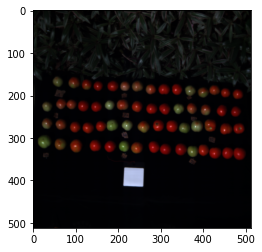

In [ ]:
hdr_path='/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/22_6_22/SOLI_256/Spectral/RAW_SPECTRAL_DATA/22_6_22 SOLI/1373/results/REFLECTANCE_1373.hdr'
soli_sideA=TomatoImage(hdr_path,hdr_path,global_band_table)
hdr_path='/content/drive/MyDrive/71254_2023/02_Assignment_Submission/Eitan.Fass/HW04/images/results/REFLECTANCE_1452.hdr'
harvest_4=TomatoImage(hdr_path,hdr_path,global_band_table)
plt.imshow(harvest_4.RGB)


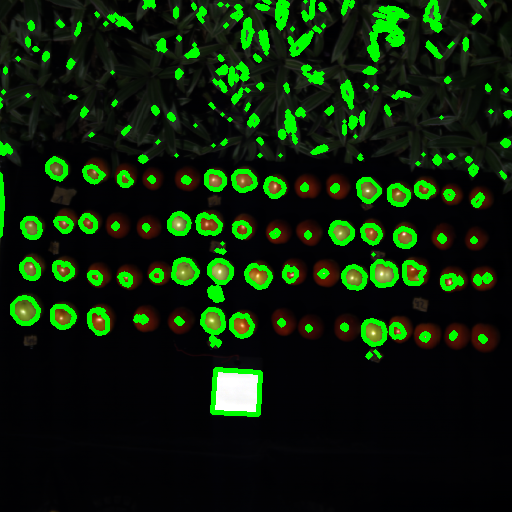

In [ ]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
# Load the classifier model
# model = cv2.CascadeClassifier('tomato classifier.xml')

# Load the image

img = cv2.imread('/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/19_10_22/SOLI_industrial/Spectral/Lab_Images/Raw_Spectarl_Data/1450/1452.png')

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Threshold the image to create a binary image
ret, thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)

# Find contours in the image
contours, _ = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Iterate through the contours and draw the polygons on the original image
for cnt in contours:
    approx = cv2.approxPolyDP(cnt, 0.01*cv2.arcLength(cnt,True),True)
    cv2.drawContours(img, [approx], 0, (0,255,0), 3)

# Show the resulting image
cv2_imshow(img)
cv2.waitKey(0)
cv2.destroyAllWindows()


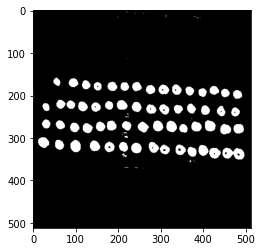

In [ ]:

img=(harvest_4.RGB*255).astype('uint8')
hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV) # convert rgb to hsv


mask = cv2.inRange(hsv, (0,30,50), (50,255,255)) # mask out the green balls. range of hsv. from hsv1 to hsv2. 
# enter the link to see the hsv color space
# https://stackoverflow.com/questions/10948589/choosing-the-correct-upper-and-lower-hsv-boundaries-for-color-detection-withcv/48367205#48367205
# we chose only h and s. v we made same as s
closed_mask = nd.binary_closing(mask, np.ones((3,2)))
# display our mask
plt.imshow(closed_mask,cmap='gray')



<ipython-input-11-1c8875d5f255>:7: FutureWarning: indices argument is deprecated and will be removed in version 0.20. To avoid this warning, please do not use the indices argument. Please see peak_local_max documentation for more details.
  localMax = peak_local_max(-D, indices=False, min_distance=10,


[INFO] 266 unique segments found


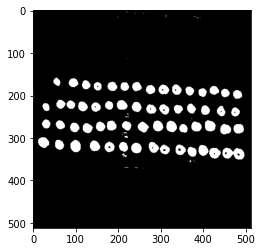

In [ ]:

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = nd.distance_transform_edt(closed_mask)

# Now we take D , our distance map, and find peaks (i.e., local maxima) in the map. We’ll ensure that is at least a 20 pixel distance between each peak.
localMax = peak_local_max(-D, indices=False, min_distance=10,
	labels=closed_mask)

# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = nd.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=closed_mask) #  matrix of labels
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # color to gray

# loop over the unique labels returned by the Watershed algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue

	# otherwise, allocate memory for the label region, and set the pixels belonging to the current label to 255 (white). draw it on the mask.
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255

	# detect contours in the mask and grab the largest one — this contour will represent the outline/boundary of a given object in the image.
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)
	cnts = imutils.grab_contours(cnts)
	c = max(cnts, key=cv2.contourArea)
 
	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(img, (int(x), int(y)), int(r), (0, 255, 0), 1)
	cv2.putText(img, "#{}".format(label), (int(x) - 10, int(y)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)
 
# show the output image
plt.imshow(harvest_4.RGB)
# display our mask
plt.imshow(closed_mask,cmap='gray')

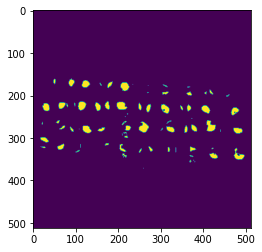

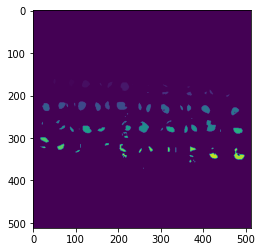

In [ ]:

nir_img=soli_sideA.spectral[:,:,110].copy()
nir_img[nir_img>0.5]=1
nir_img[nir_img<=0.5]=0

nir_img = nd.binary_closing(nir_img, np.ones((5,5)))
new_mask=nir_img*closed_mask
plt.imshow(new_mask)
plt.show()
# lets label our blue balls, each one will get a different color
label_image = measure.label(new_mask)
plt.imshow(label_image)

In [ ]:
from skimage.color import label2rgb
image_label_overlay = label2rgb(label_image, image=harvest_4.RGB) # display the labels, abovee our original iamge (img)
# plt.imshow(image_label_overlay)

# lets get info about the blue balls (using measure)

props = measure.regionprops_table(label_image, img,
                                  properties= ['label',
                                               'area', 'equivalent_diameter', 
                                               'mean_intensity', 'solidity'])


df = pd.DataFrame(props)
df1=df[df['area']>100]
df1

<ipython-input-13-9a1420cd64a9>:2: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  image_label_overlay = label2rgb(label_image, image=harvest_4.RGB) # display the labels, abovee our original iamge (img)


label  area  equivalent_diameter  mean_intensity-0  mean_intensity-1  \
0       1   163            14.406181          5.926380          7.742331   
2       3   236            17.334490          1.271186          2.495763   
4       5   308            19.802974          7.353896         22.665584   
16     17   145            13.587484          3.186207         10.655172   
17     18   291            19.248707          7.522337          2.292096   
18     19   333            20.590988         11.909910         21.294294   
19     20   190            15.553633         10.468421         10.436842   
20     21   181            15.180789          2.867403          3.071823   
23     24   231            17.149879          3.692641          7.095238   
25     26   137            13.207340          9.919708          6.569343   
26     27   279            18.847648          4.935484          4.100358   
29     30   261            18.229523          2.800766          2.754789   
30     31   210            16.351768          2.976190          2.633333   
35     36   352            21.170270          7.789773          3.482955   
38     39   369            21.675456          8.593496         15.766938   
40     41   145            13.587484          9.813793         20.896552   
42     43   117            12.205287          1.752137          6.239316   
44     45   263            18.299235         10.501901         12.395437   
46     47   183            15.264430         35.409836         31.000000   
49     50   219            16.698487          6.063927          5.378995   
57     58   147            13.680870         19.081633         29.054422   
59     60   138            13.255454         11.775362         18.652174   
61     62   111            11.888212          5.882883         12.432432   
69     70   287            19.115955         12.909408          1.742160   
72     73   167            14.581872         54.952096         36.311377   

    mean_intensity-2  solidity  
0         231.386503  0.905556  
2         248.627119  0.963265  
4         215.961039  0.944785  
16        239.813793  0.935484  
17        229.900344  0.950980  
18        208.354354  0.938028  
19        225.031579  0.954774  
20        242.508287  0.937824  
23        242.000000  0.942857  
25        229.262774  0.938356  
26        240.706093  0.917763  
29        248.222222  0.956044  
30        242.990476  0.921053  
35        232.301136  0.807339  
38        221.173442  0.874408  
40        220.662069  0.941558  
42        243.153846  0.886364  
44        219.699620  0.959854  
46        146.147541  0.938462  
49        234.319635  0.956332  
57        163.693878  0.930380  
59        207.847826  0.920000  
61        228.072072  0.587302  
69        220.121951  0.642058  
72         95.928144  0.902703

#creating objects from data


In [6]:
harvest_1_lab_results_path='/content/drive/MyDrive/Shared_tomato/1_Data_shared/2021/2021_08_15/LEKET/Lab/2021_08_15_LEKET_ID1_27.csv'
harvest_1_reflectence_path="/content/drive/MyDrive/Shared_tomato/Eitan/LEKET_FARM_15_08_2021/SPECTRAL_DATA/reflectence_mean_ID1_27.csv"
harvest_1=Harvest('Roma',harvest_1_lab_results_path,harvest_1_reflectence_path)

In [7]:
harvest_2_lab_results_path='/content/drive/MyDrive/Shared_tomato/1_Data_shared/2021/2021_10_13/ROMA_AS200/Lab/2021_10_13 _ROMA_AS200_ID1_320_All.csv'
harvest_2_reflectence_path='/content/drive/MyDrive/Shared_tomato/Eitan/ROMA_AS200_13_10_2021/SPECTRAL_DATA/Reflectence_ID1_320.csv'
harvest_2=Harvest('Roma',harvest_2_lab_results_path,harvest_2_reflectence_path)

In [8]:
harvest_3_lab_results_path="/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/22_6_22/SOLI_256/Lab/chemical_results_soli_id_1_40.csv"
harvest_3_reflectence_path="/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/22_6_22/SOLI_256/Spectral/2022_6_22_SOLI_Medien_ID1_40.csv"
harvest_3=Harvest('Singel Round',harvest_3_lab_results_path,harvest_3_reflectence_path)


In [9]:
harvest_4_reflectence_path='/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/19_10_22/SOLI_industrial/Spectral/Lab_Images/2022_10_19_SOLI_industial_Mean_ID1_60.csv'
harvest_4_lab_results_path='/content/drive/MyDrive/Shared_tomato/1_Data_shared/2022/19_10_22/SOLI_industrial/Lab/2022_10_19_Chemical_Results_SOLI_industrial_ID1_60.csv'
harvest_4=Harvest('Clusters Round',harvest_4_lab_results_path,harvest_4_reflectence_path)


In [10]:
tomato_list1234=TomatoList([harvest_1,harvest_2,harvest_3,harvest_4])#create TomatoList objects
tomato_list134=TomatoList([harvest_1,harvest_3,harvest_4])
tomato_list1=TomatoList([harvest_1])
tomato_list2=TomatoList([harvest_2])
tomato_list3=TomatoList([harvest_3])
tomato_list4=TomatoList([harvest_4])
tomato_list12=TomatoList([harvest_1,harvest_2])
tomato_list34=TomatoList([harvest_3,harvest_4])

#histograms

##harvests 1,2,3,4 histograms

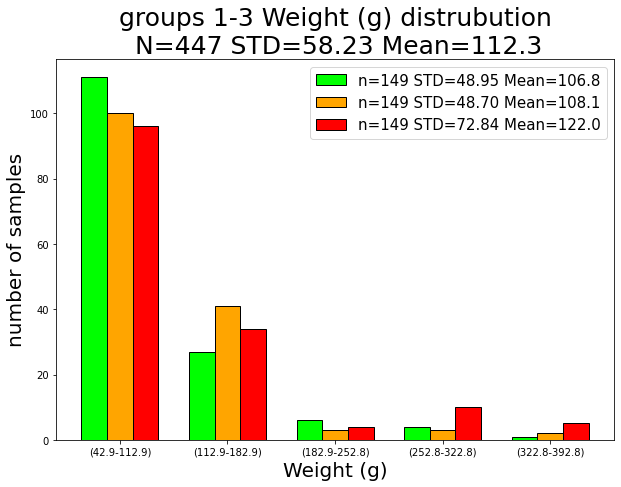

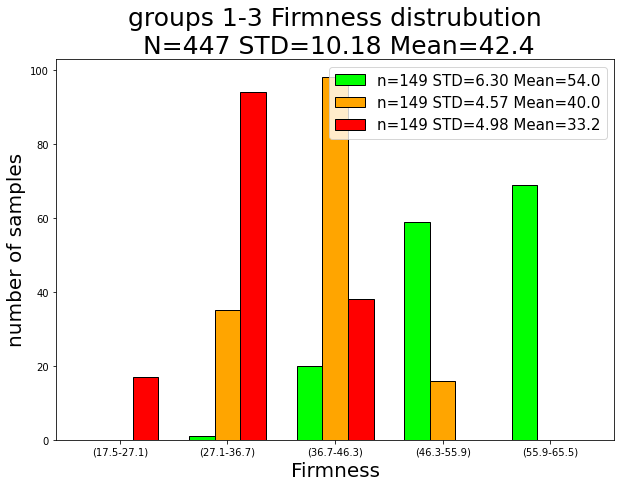

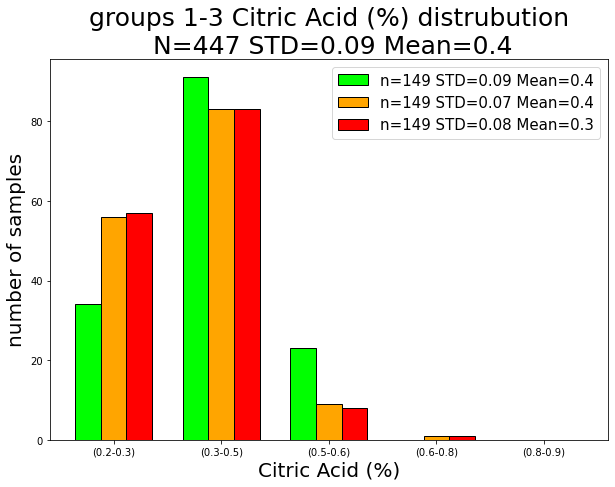

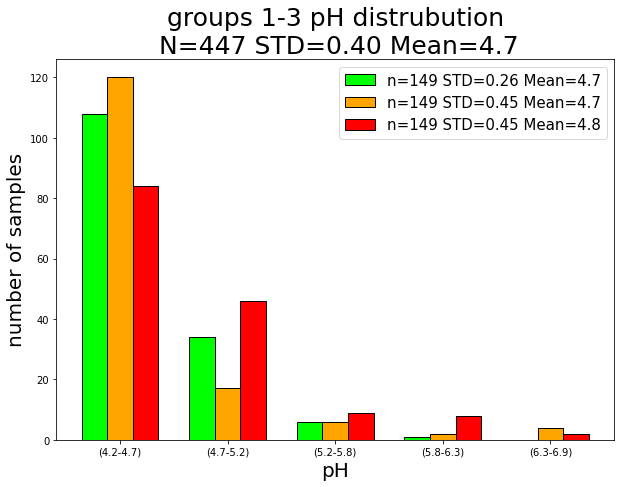

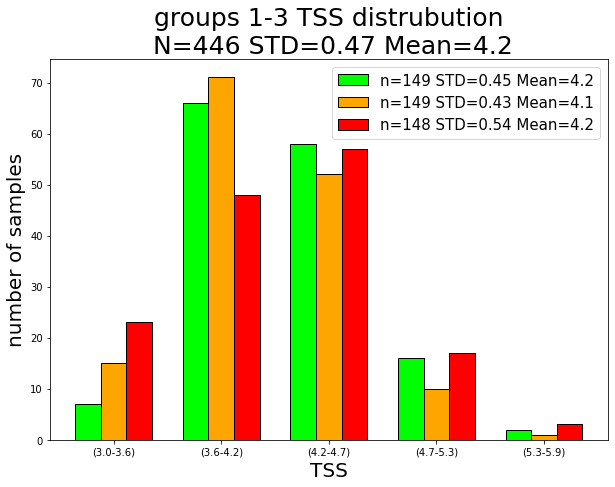

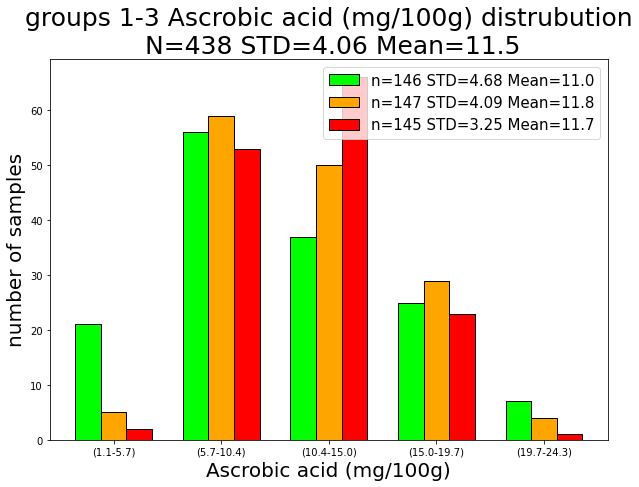

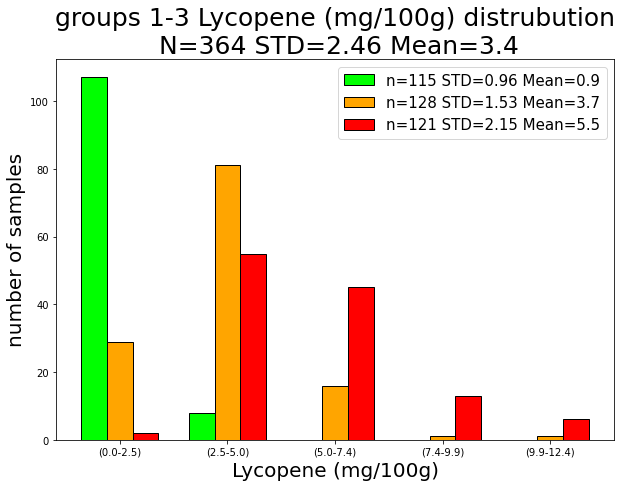

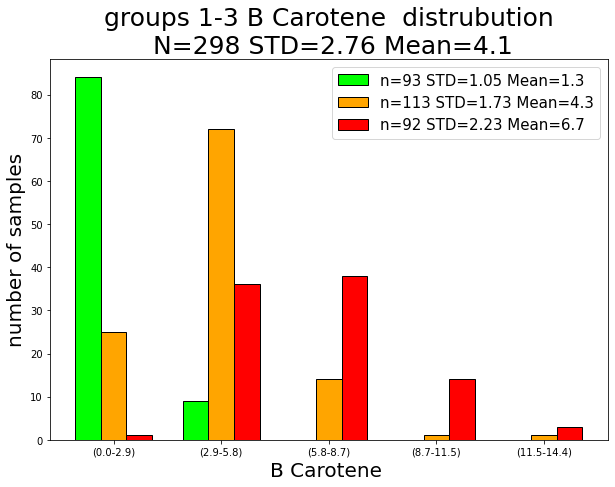

In [ ]:
histograms(tomato_list, categories=5)

##harvests 1,3,4 histograms

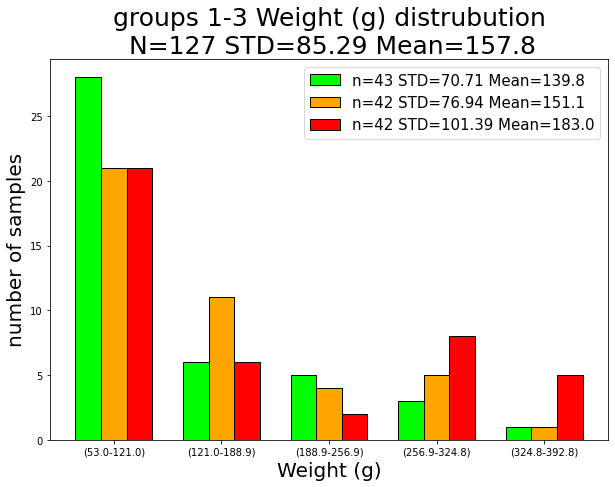

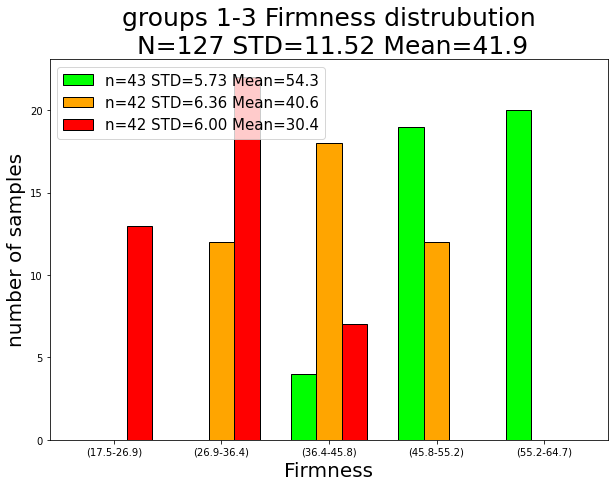

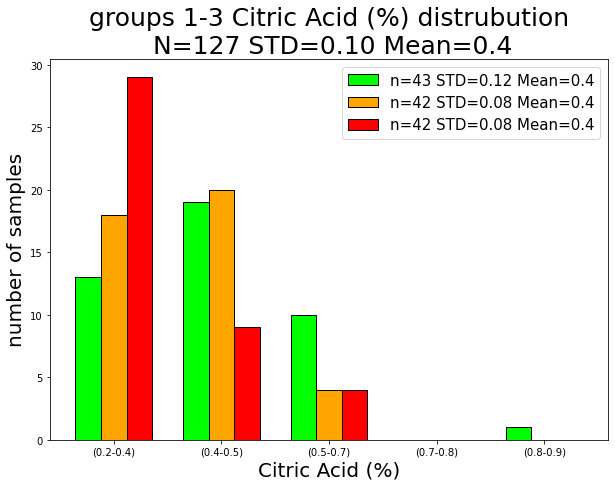

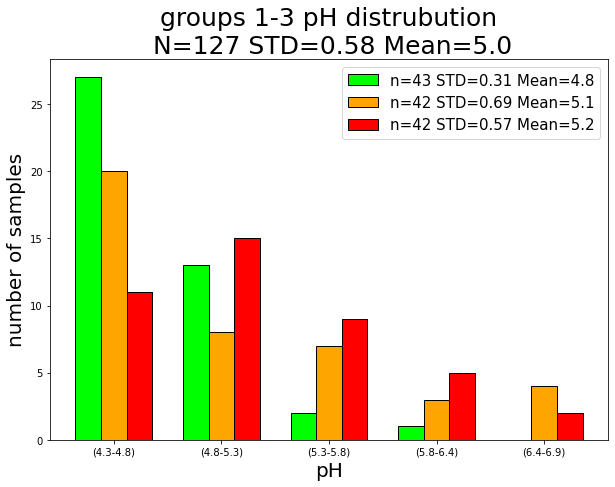

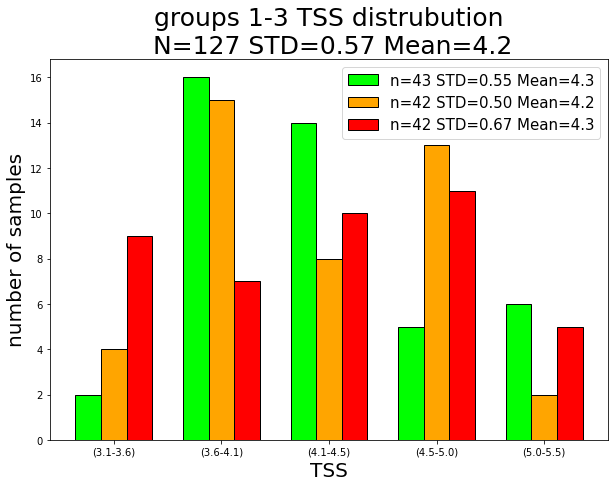

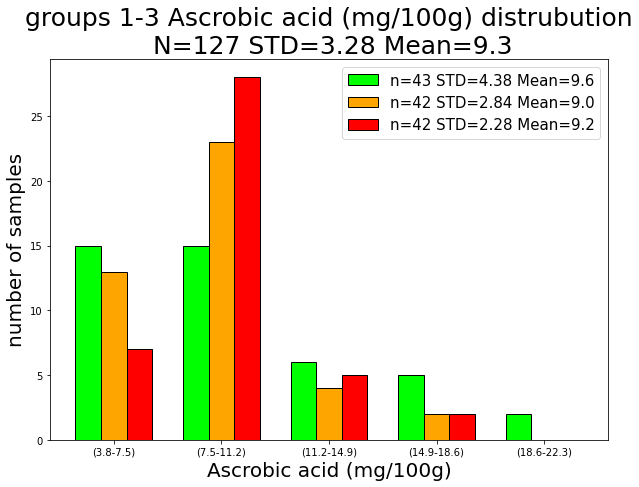

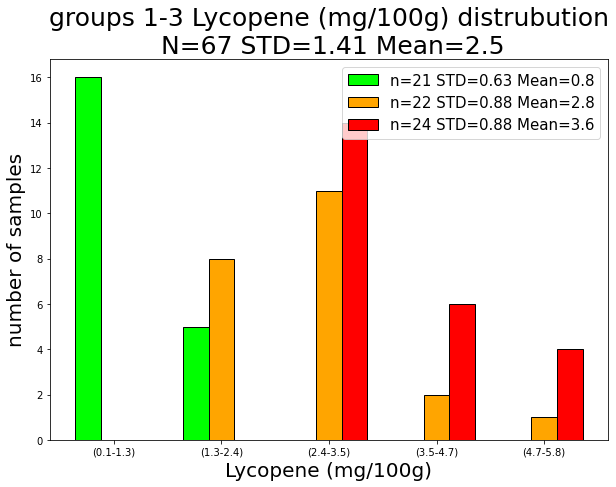

In [ ]:
histograms(tomato_list134, categories=5)

##harvest 1 histograms

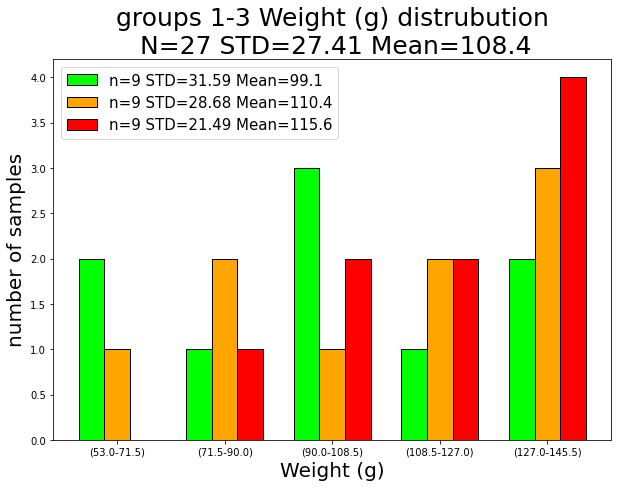

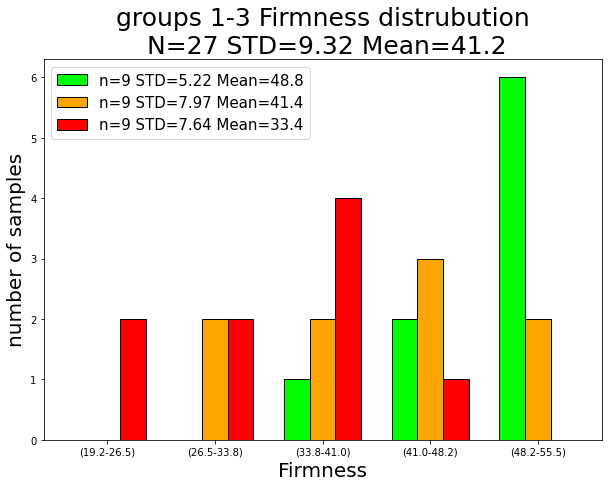

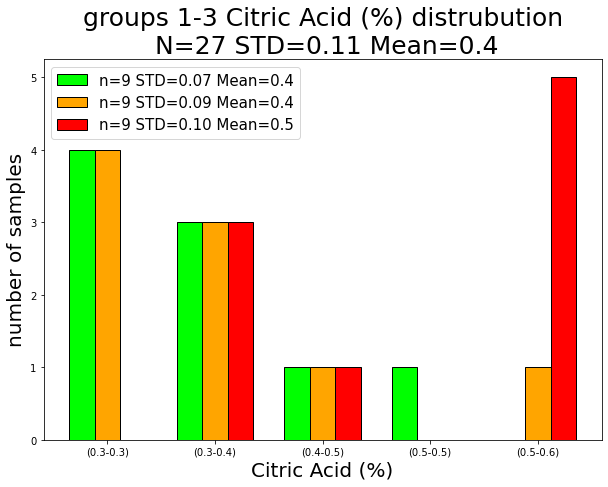

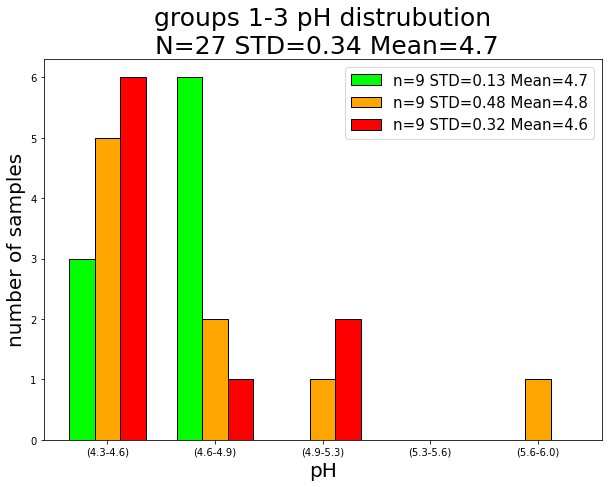

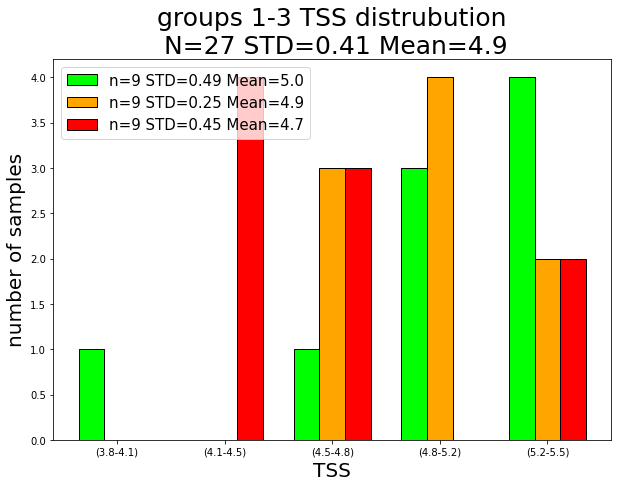

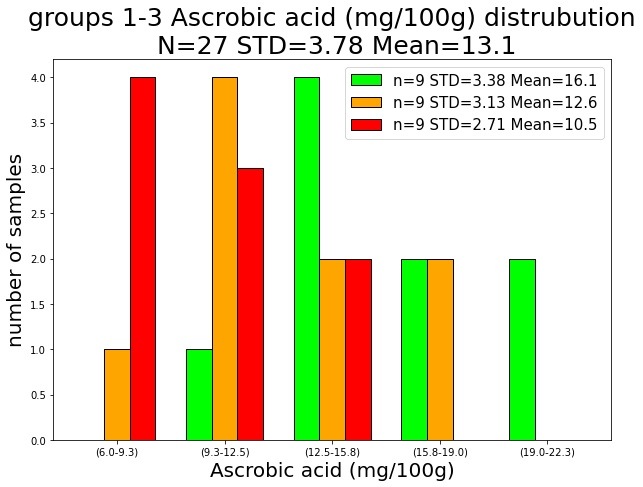

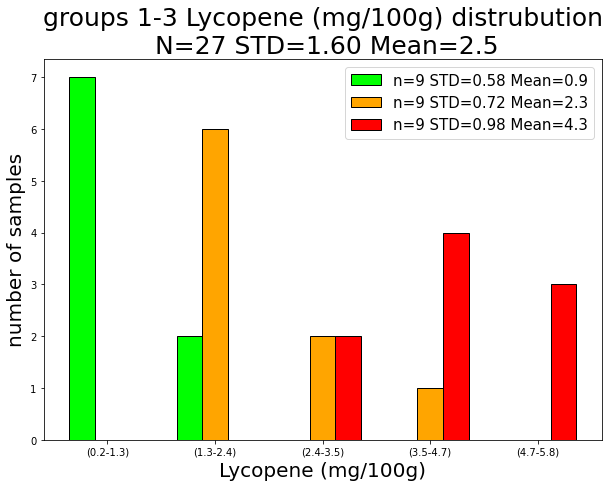

In [ ]:
histograms(tomato_list1, categories=5)

##harvest 2 histograms

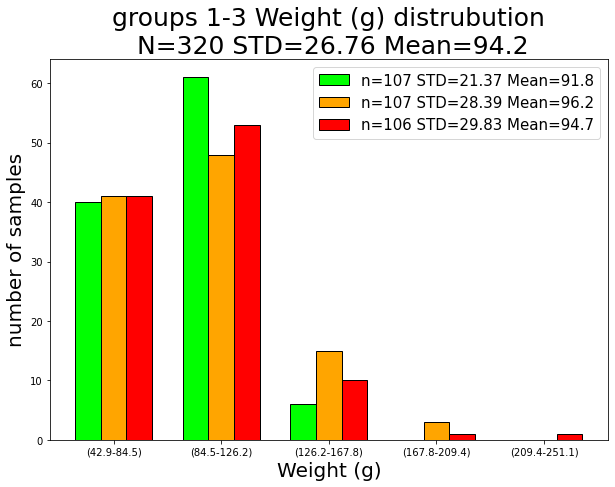

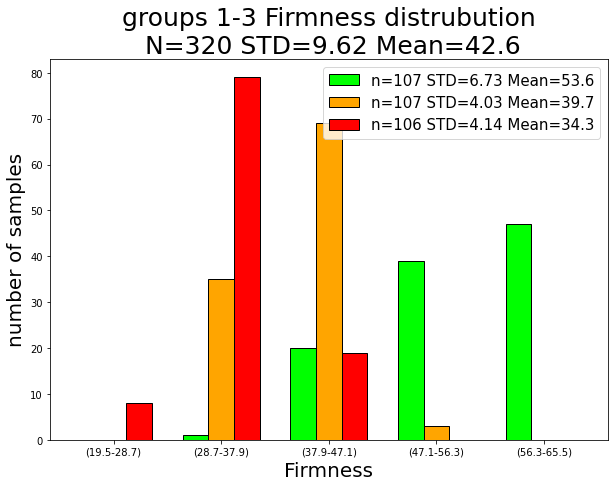

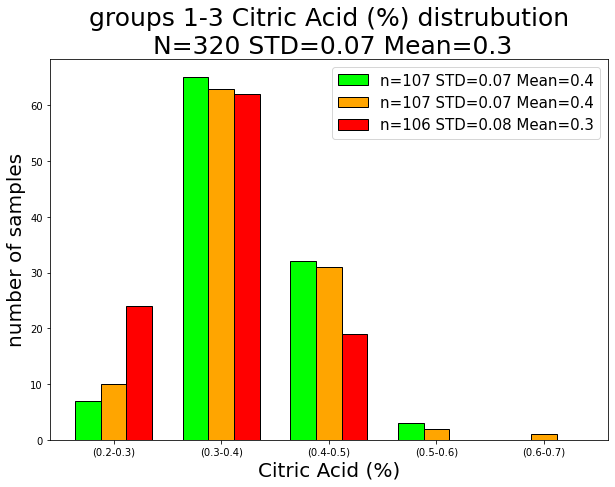

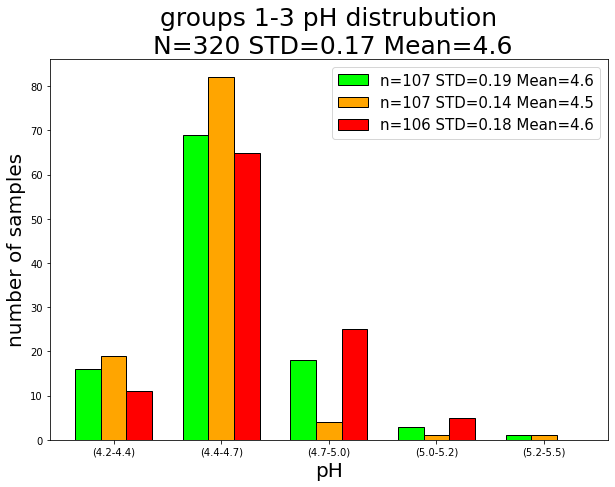

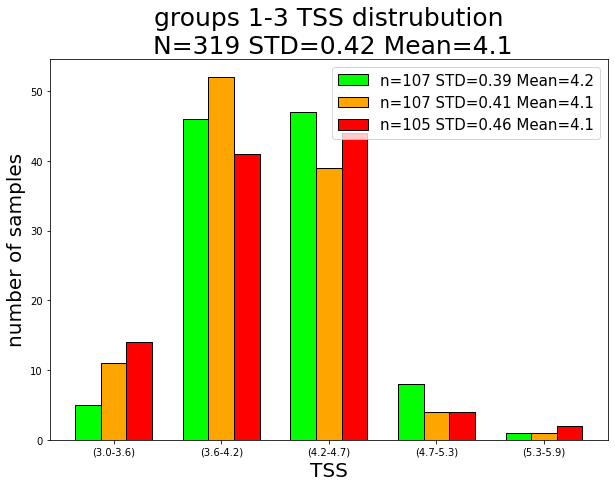

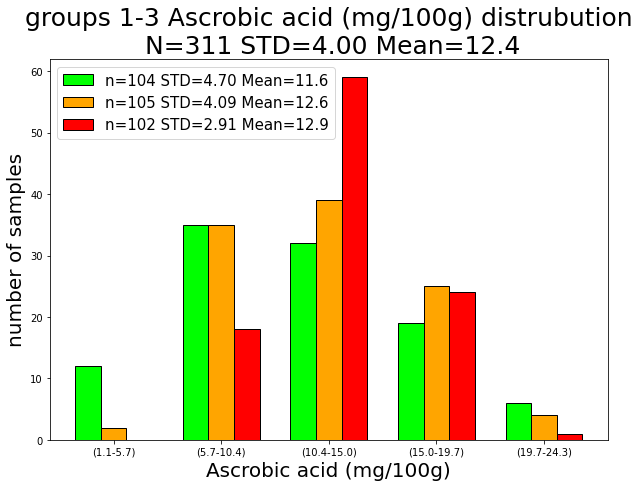

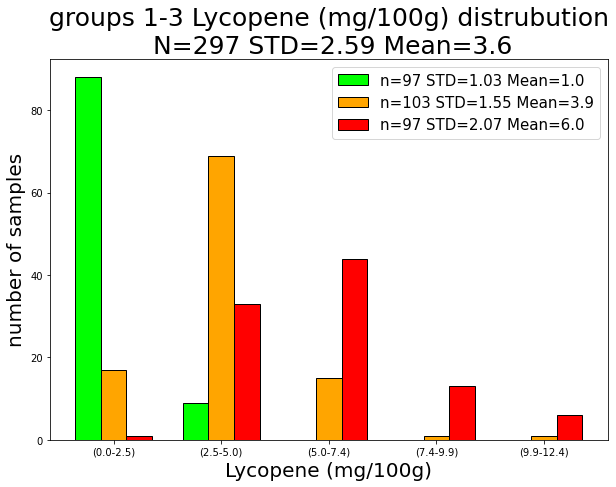

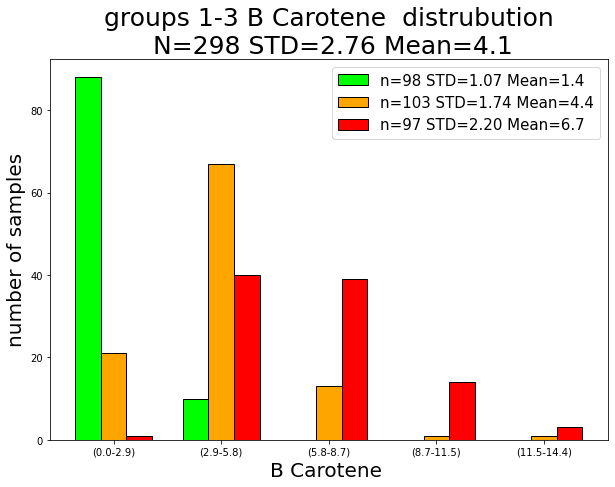

In [ ]:
histograms(tomato_list2, categories=5)

##harvests 3 histograms

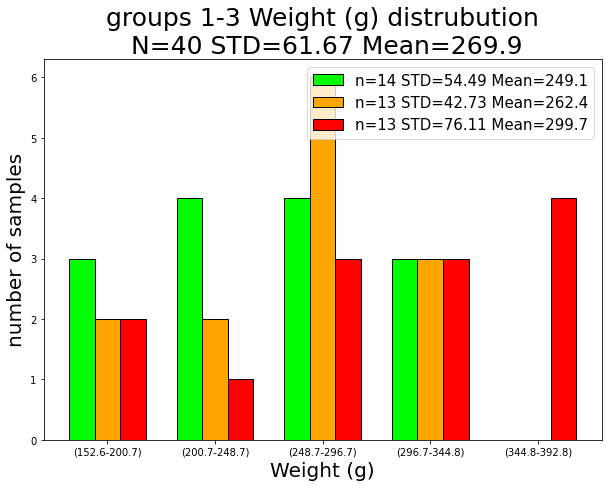

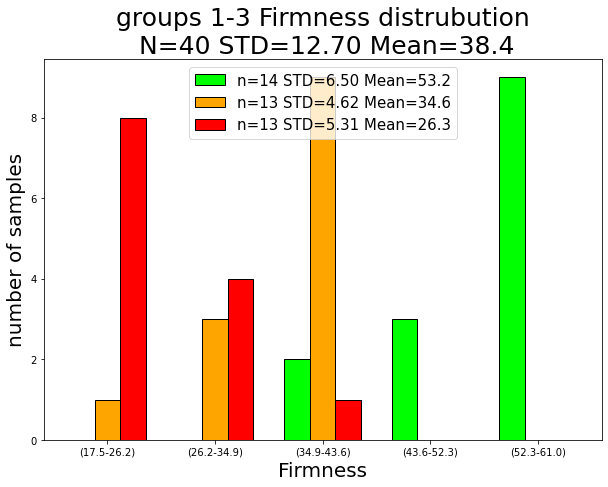

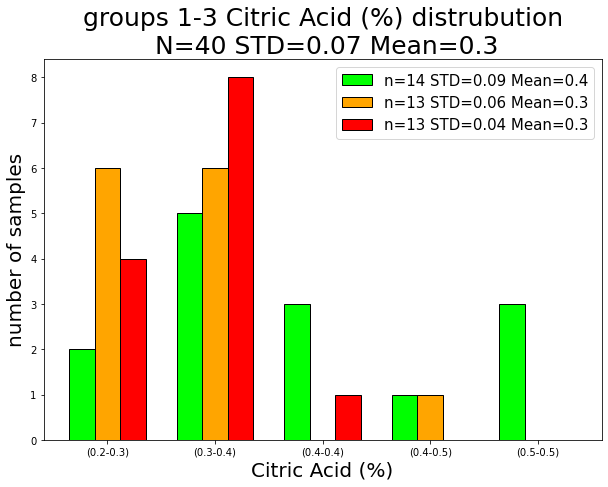

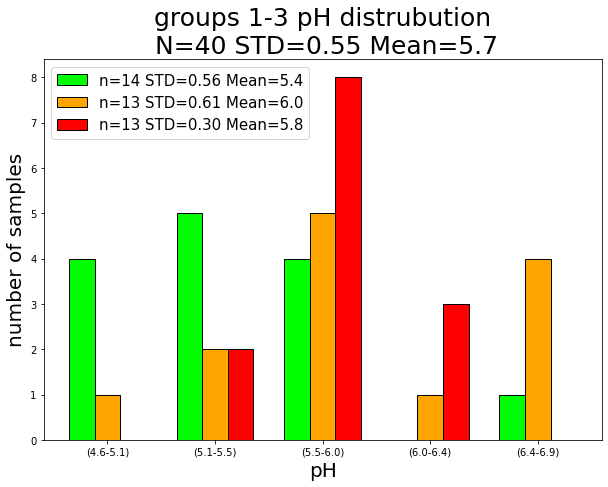

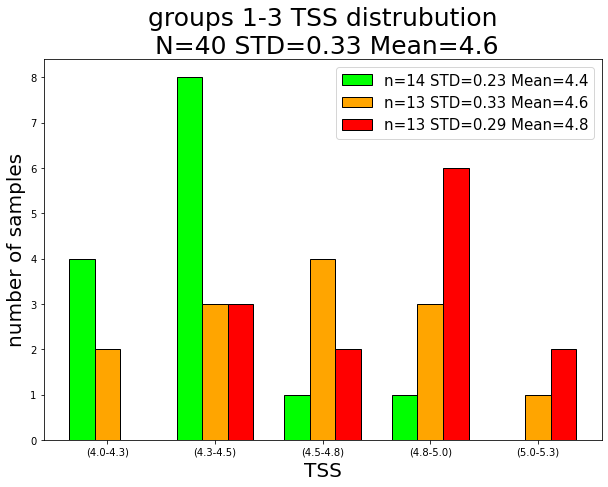

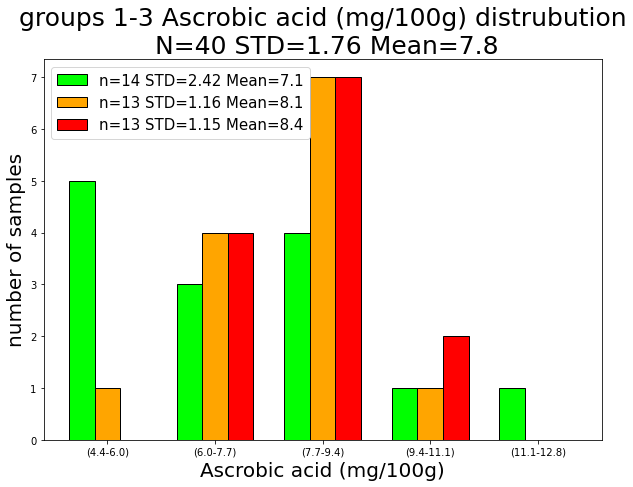

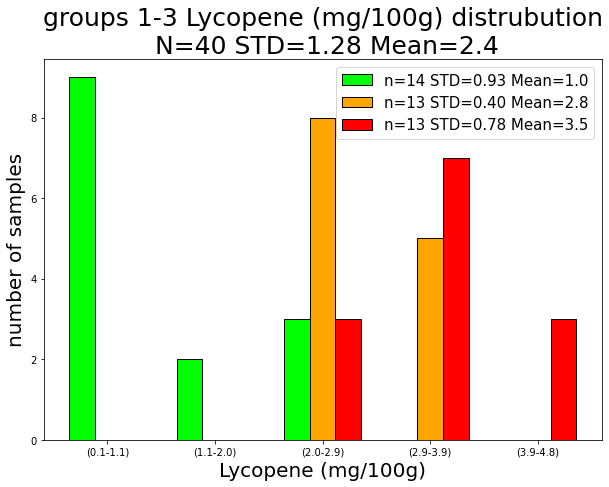

In [ ]:
histograms(tomato_list3, categories=5)

##harvests 4 histograms

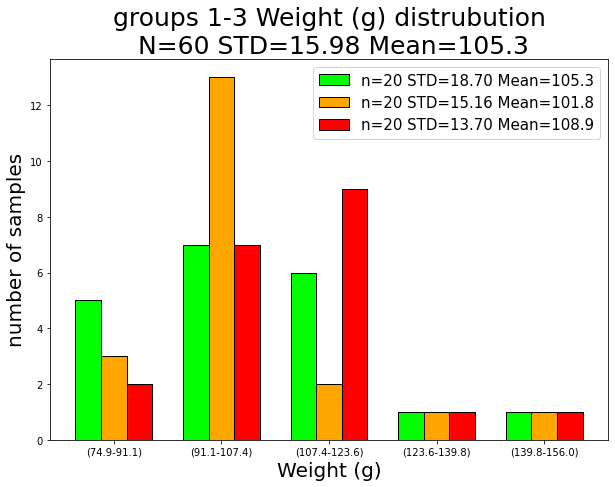

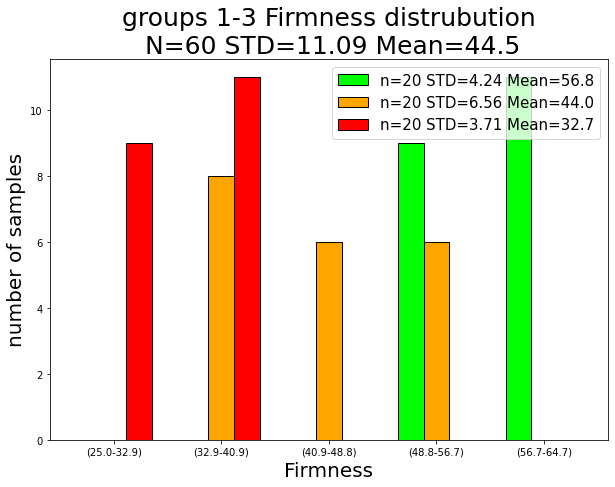

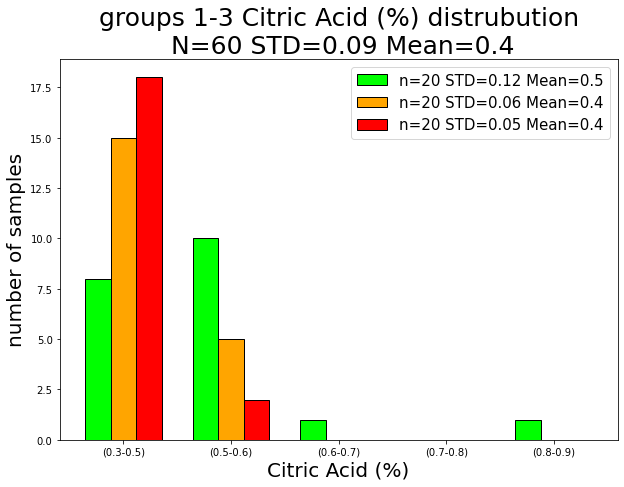

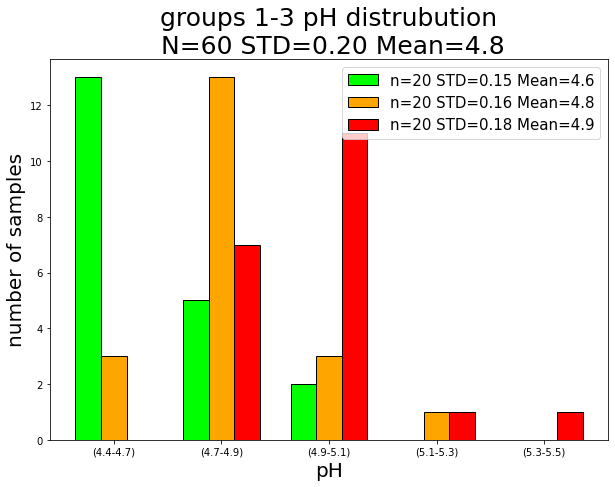

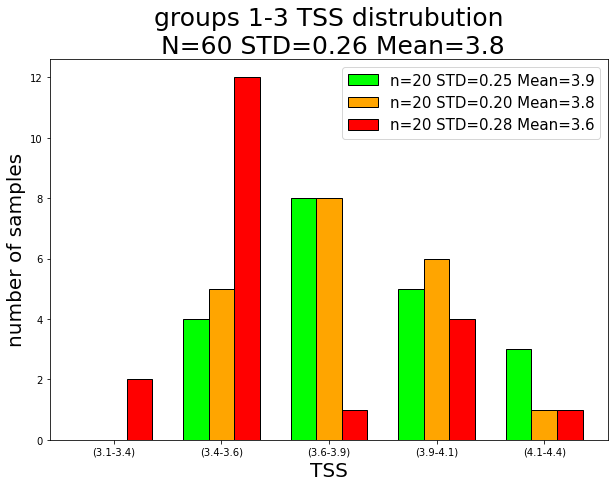

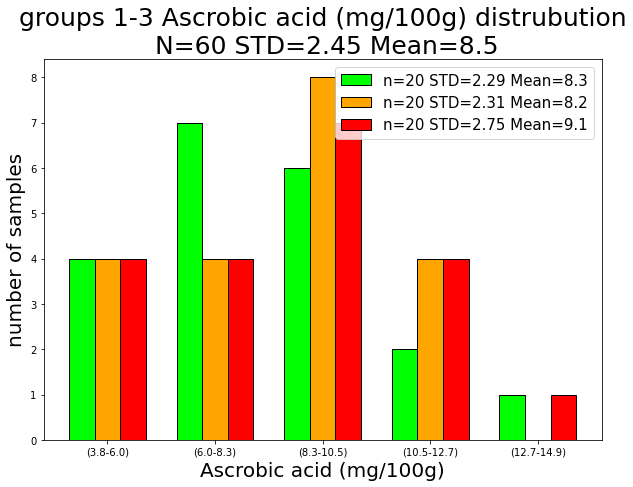

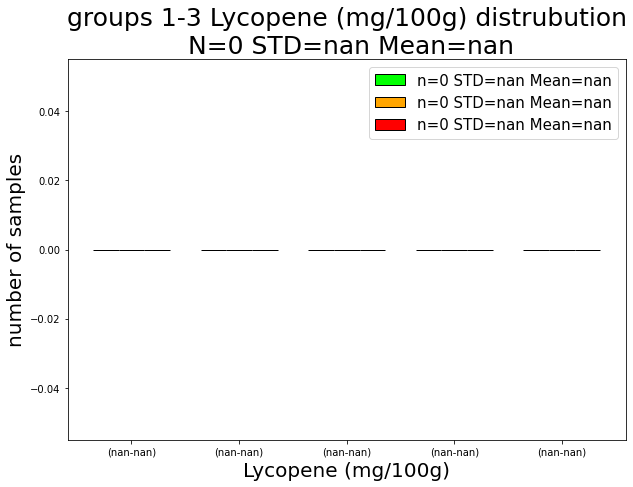

In [ ]:
histograms(tomato_list4, categories=5)

#colormaps

##$R^2$ colormap for harvest 1

/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


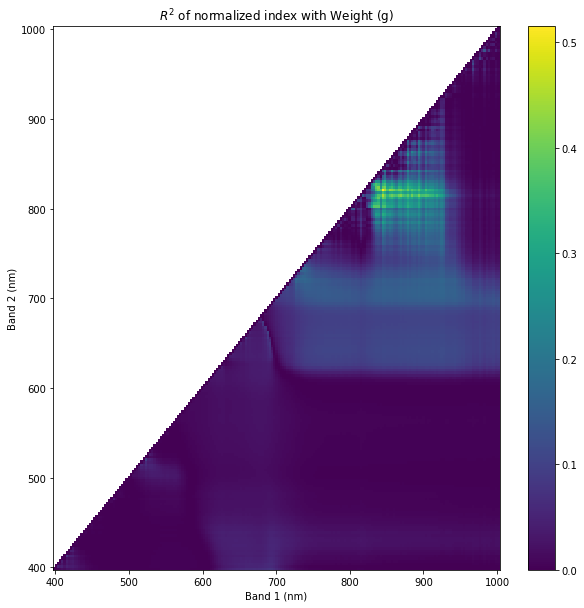

<Figure size 432x288 with 0 Axes>

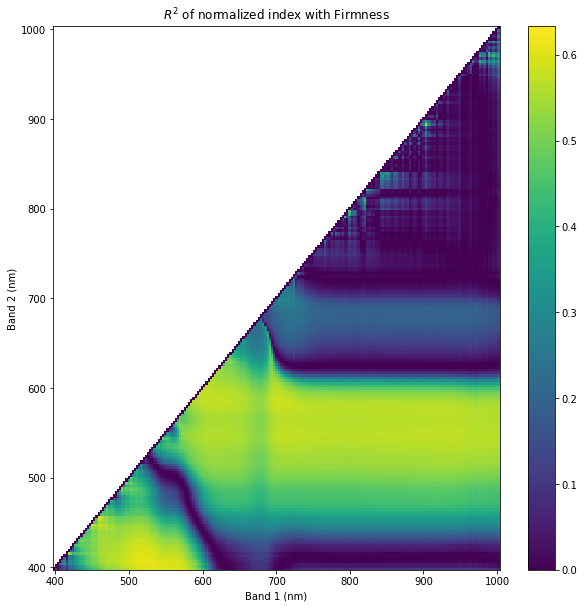

<Figure size 432x288 with 0 Axes>

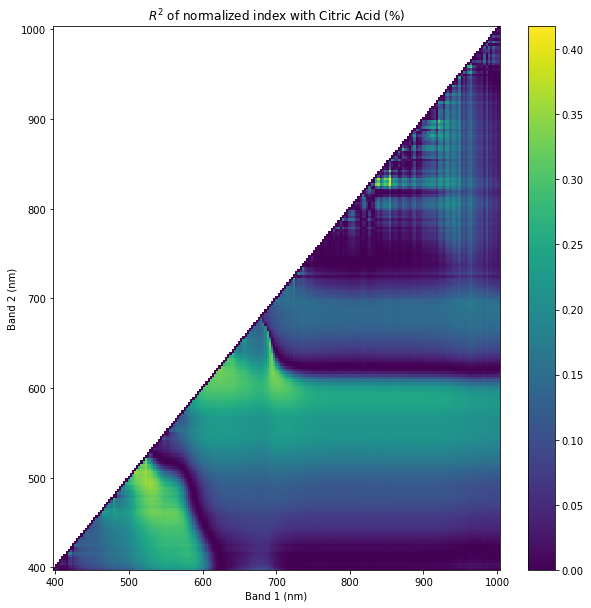

<Figure size 432x288 with 0 Axes>

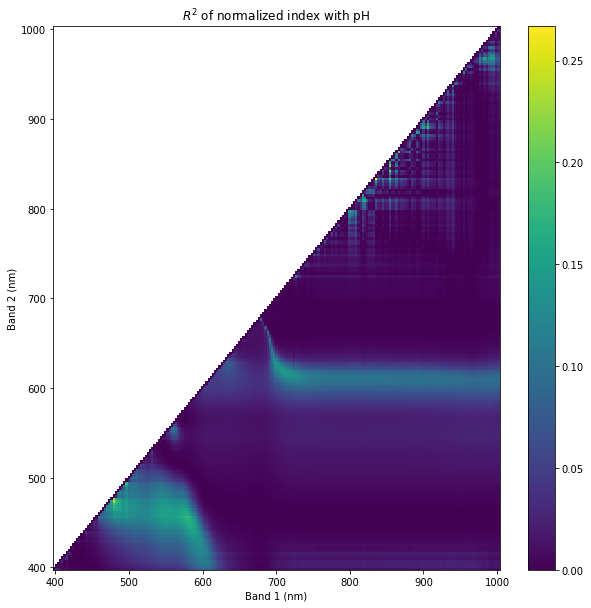

<Figure size 432x288 with 0 Axes>

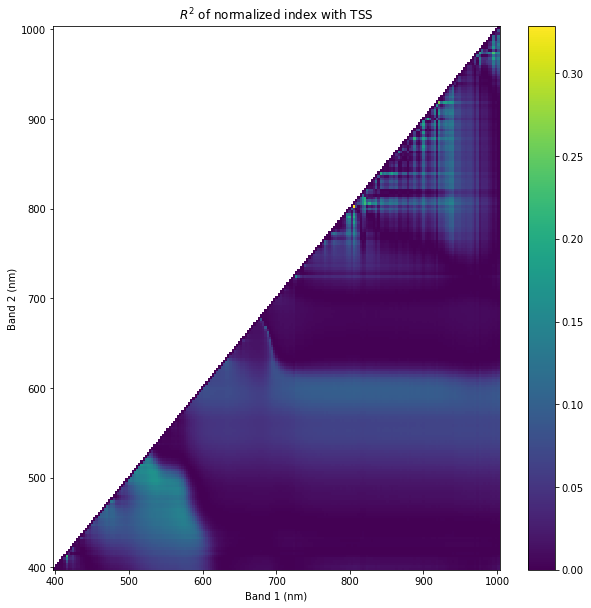

<Figure size 432x288 with 0 Axes>

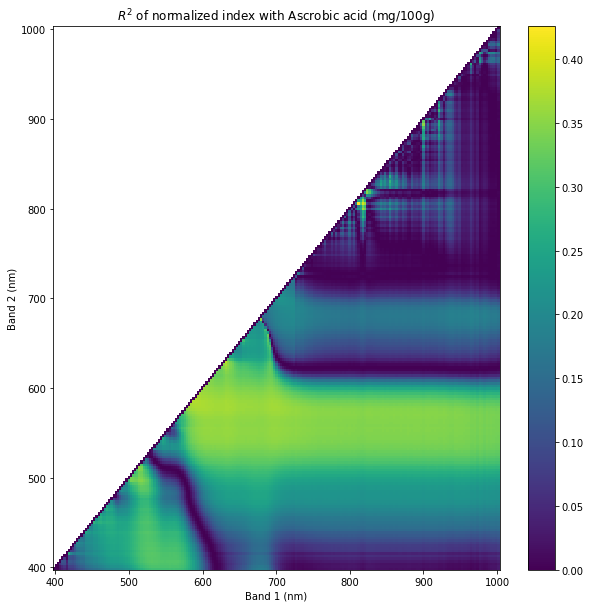

<Figure size 432x288 with 0 Axes>

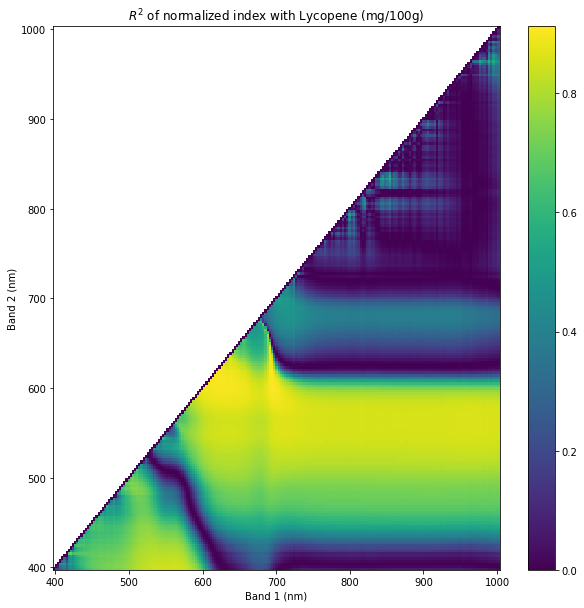

<Figure size 432x288 with 0 Axes>

In [ ]:
tomato_list1.get_color_maps([1])


##$R^2$ colormap for harvest 2

/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


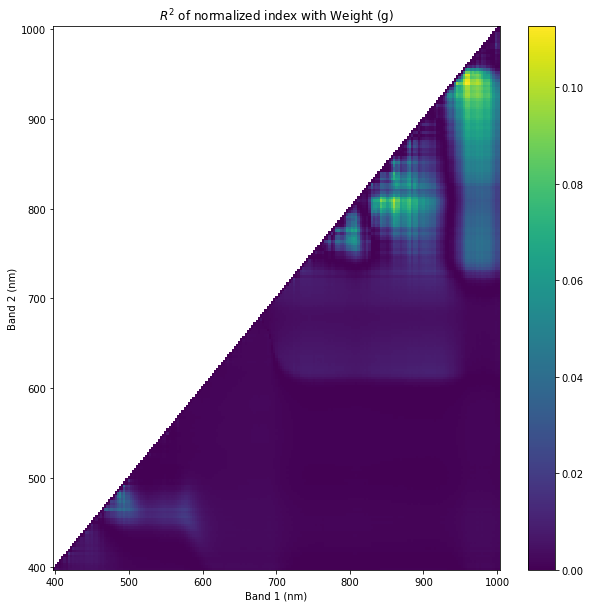

<Figure size 432x288 with 0 Axes>

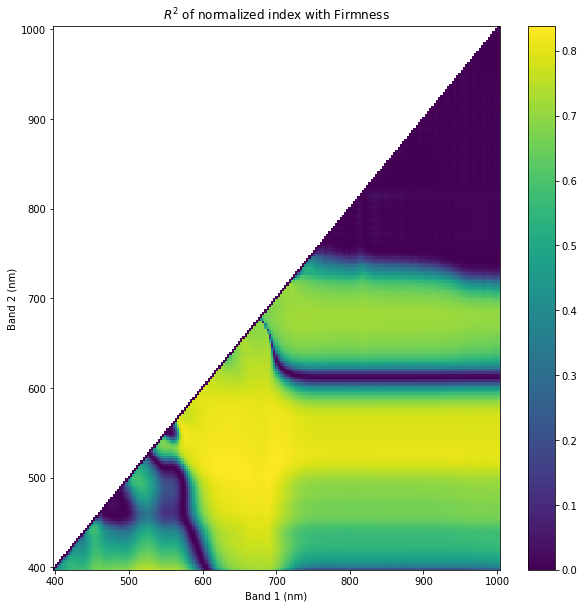

<Figure size 432x288 with 0 Axes>

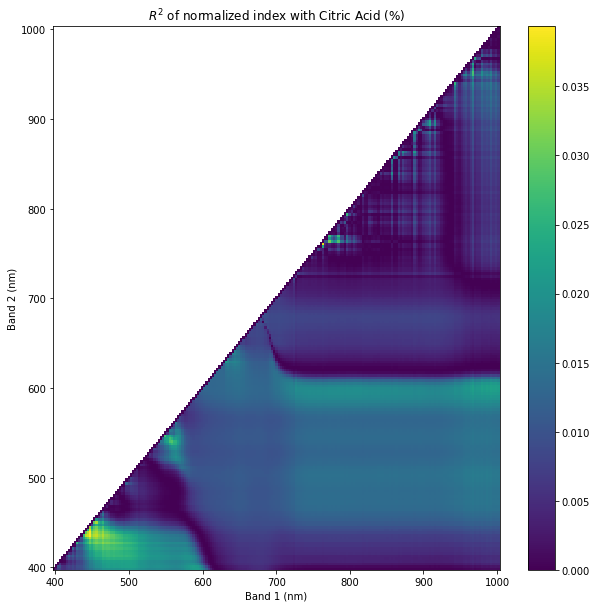

<Figure size 432x288 with 0 Axes>

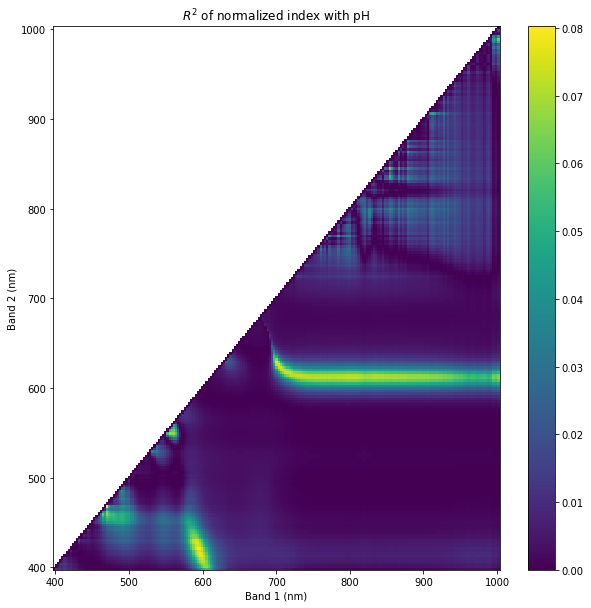

<Figure size 432x288 with 0 Axes>

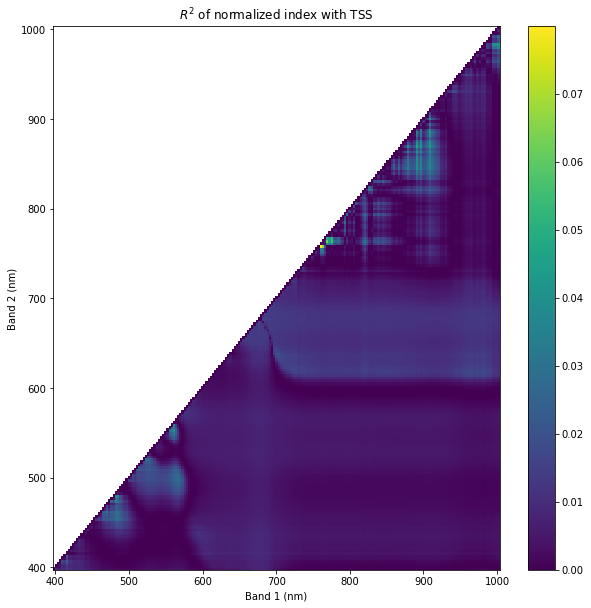

<Figure size 432x288 with 0 Axes>

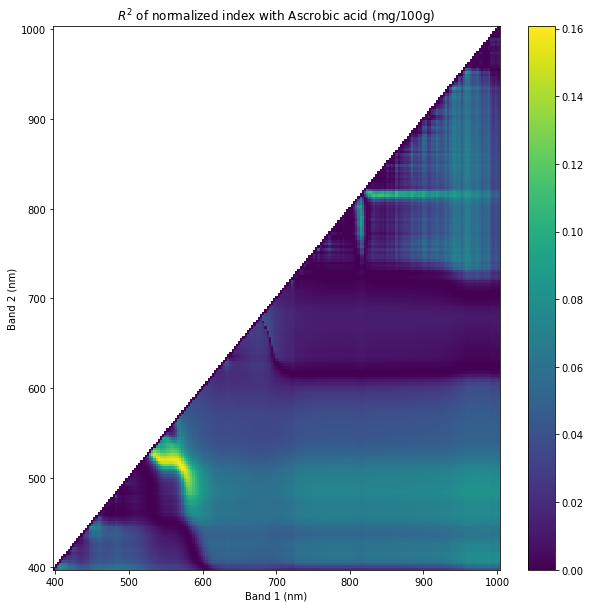

<Figure size 432x288 with 0 Axes>

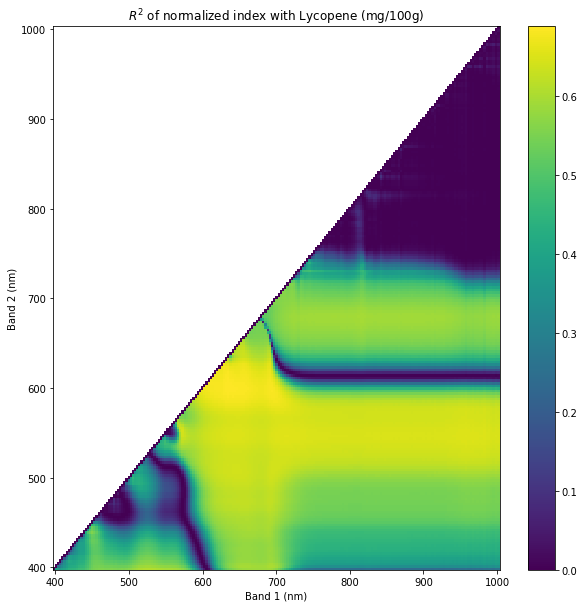

<Figure size 432x288 with 0 Axes>

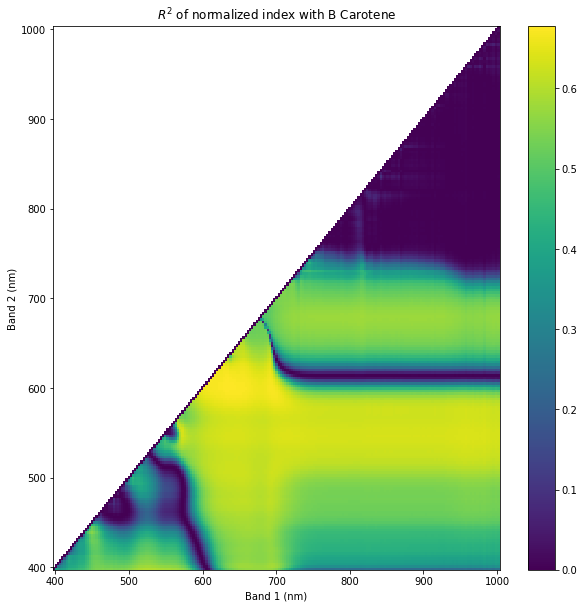

<Figure size 432x288 with 0 Axes>

In [ ]:
tomato_list2.get_color_maps([1])

##$R^2$ colormap for harvest 3

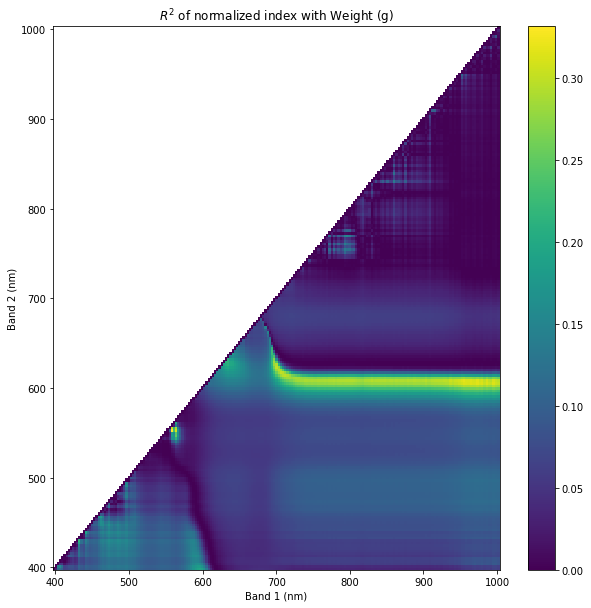

<Figure size 432x288 with 0 Axes>

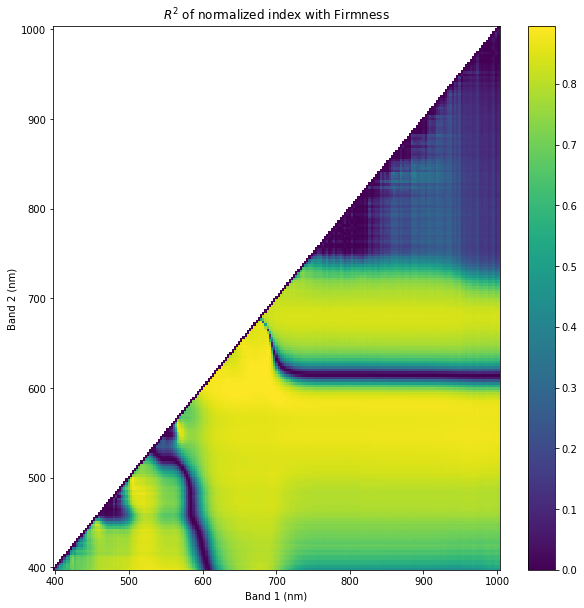

<Figure size 432x288 with 0 Axes>

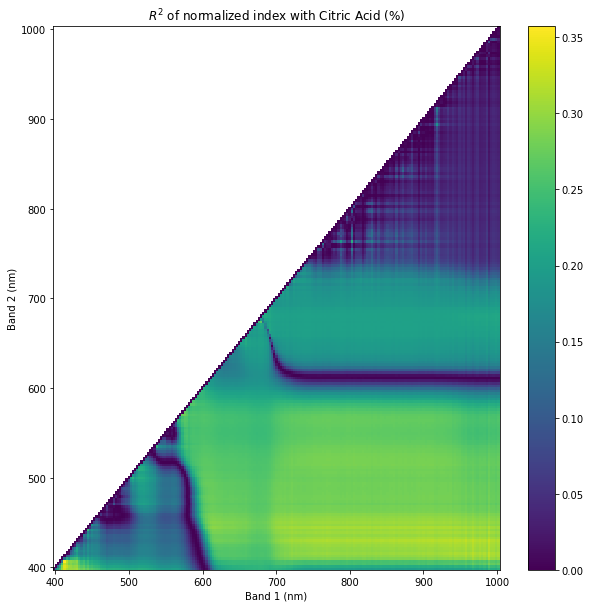

<Figure size 432x288 with 0 Axes>

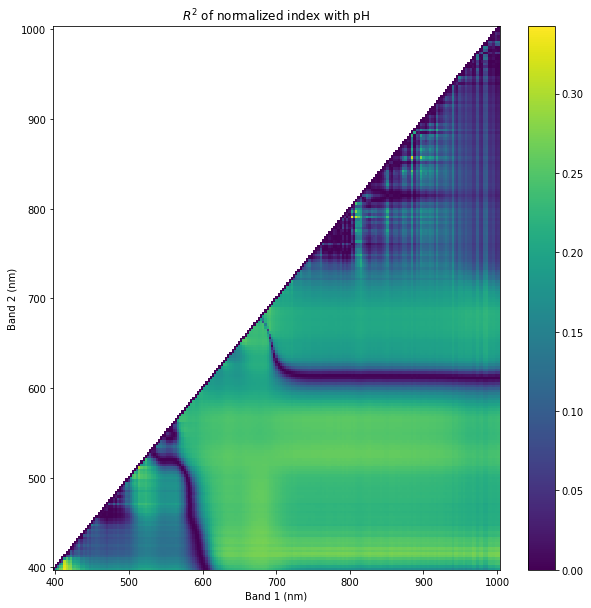

<Figure size 432x288 with 0 Axes>

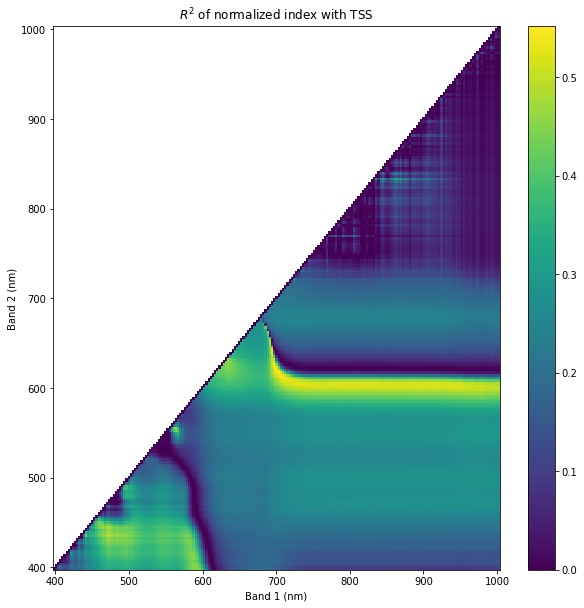

<Figure size 432x288 with 0 Axes>

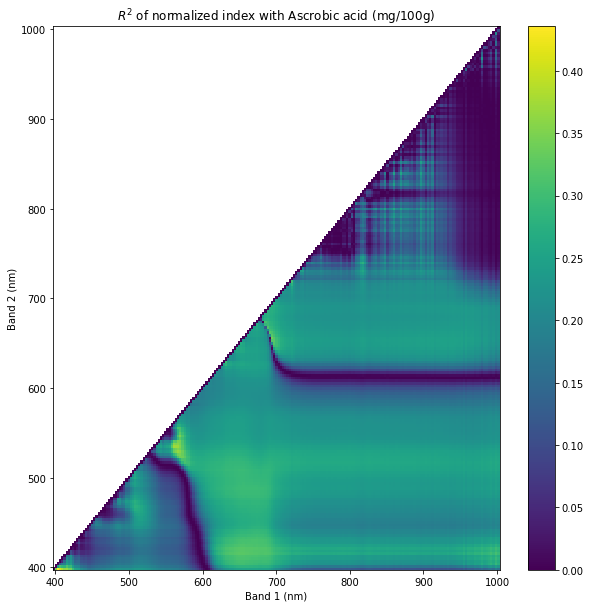

<Figure size 432x288 with 0 Axes>

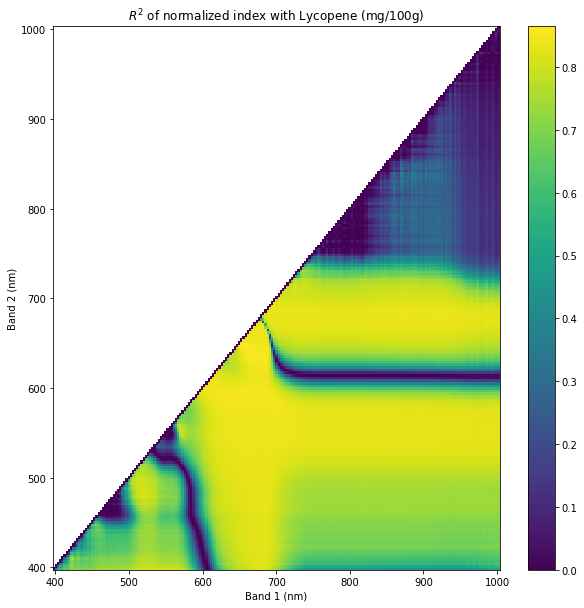

<Figure size 432x288 with 0 Axes>

In [ ]:
tomato_list3.get_color_maps([1])

##$R^2$ colormap for harvest 4




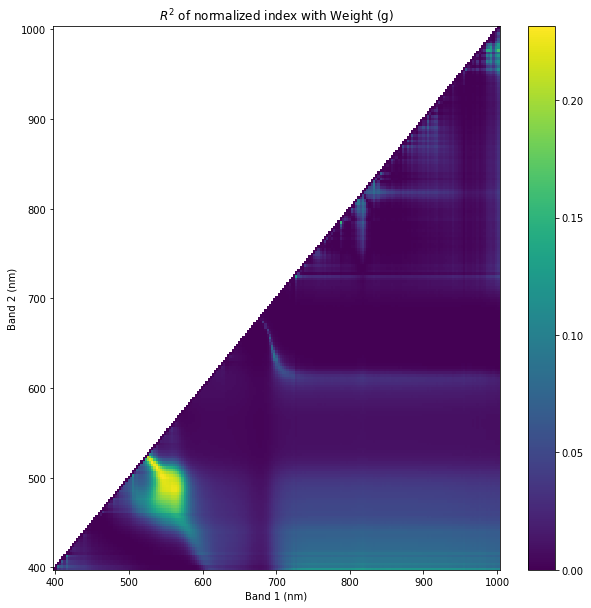

<Figure size 432x288 with 0 Axes>

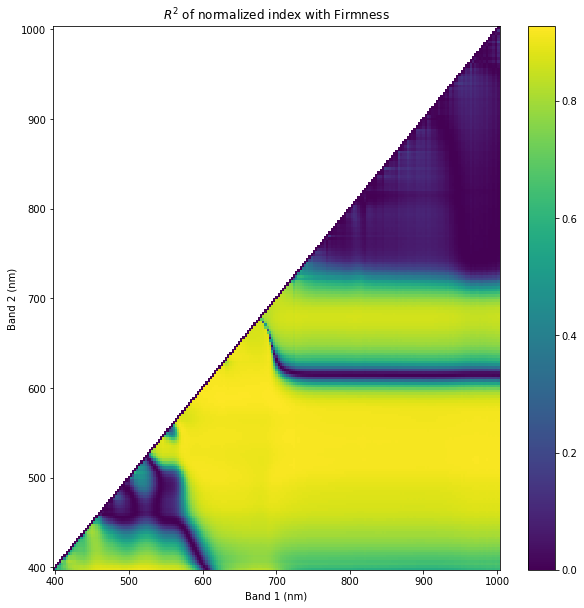

<Figure size 432x288 with 0 Axes>

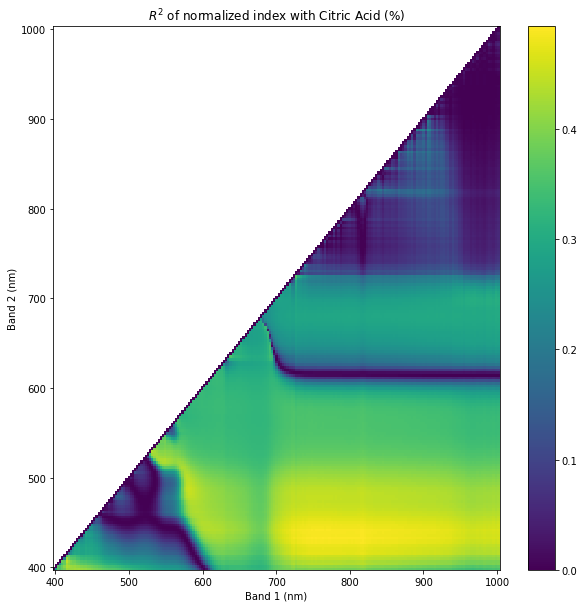

<Figure size 432x288 with 0 Axes>

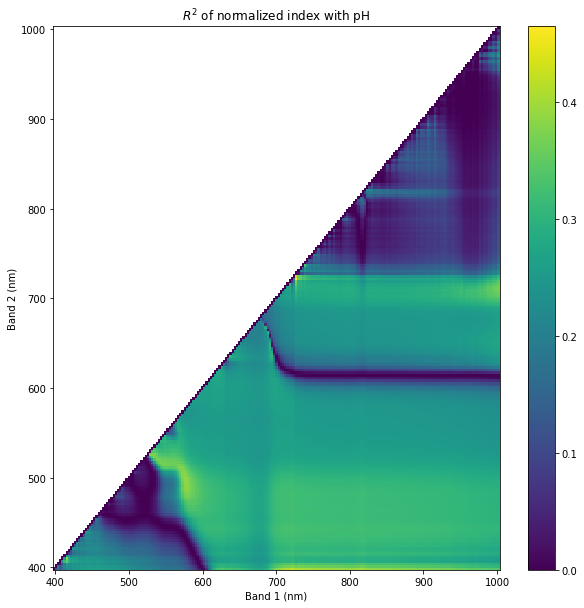

<Figure size 432x288 with 0 Axes>

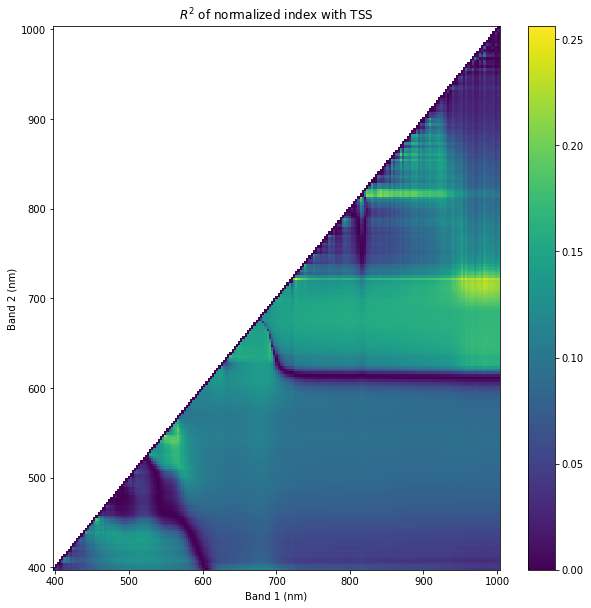

<Figure size 432x288 with 0 Axes>

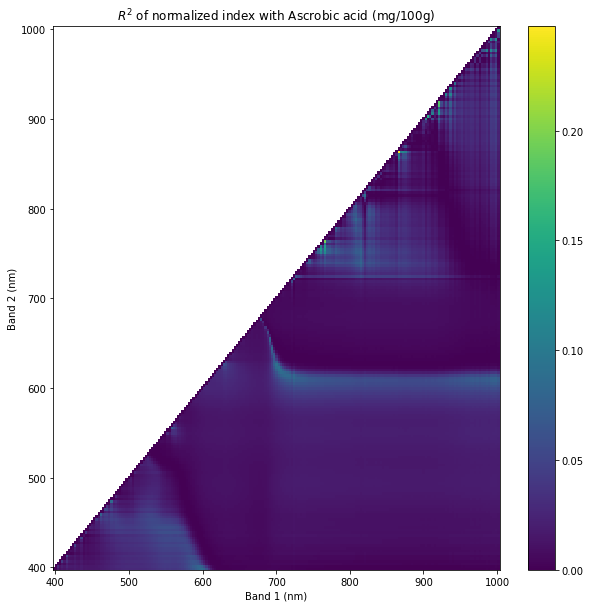

<Figure size 432x288 with 0 Axes>

In [ ]:
tomato_list4.get_color_maps([1])

##$R^2$ colormap for harvests 1,2,3,4




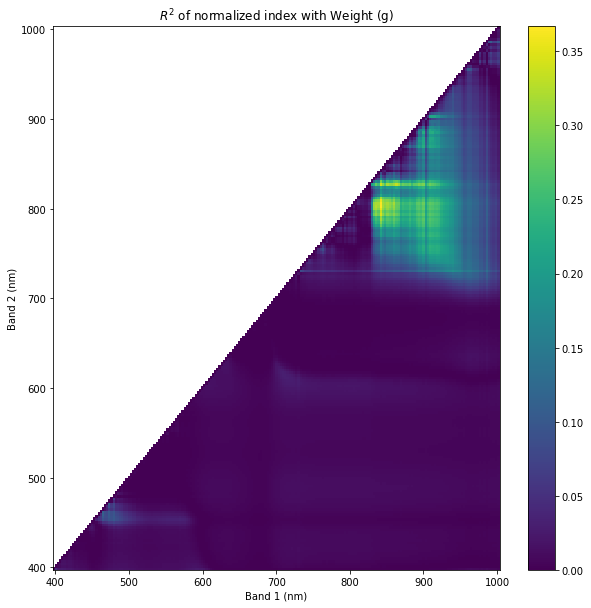

<Figure size 432x288 with 0 Axes>

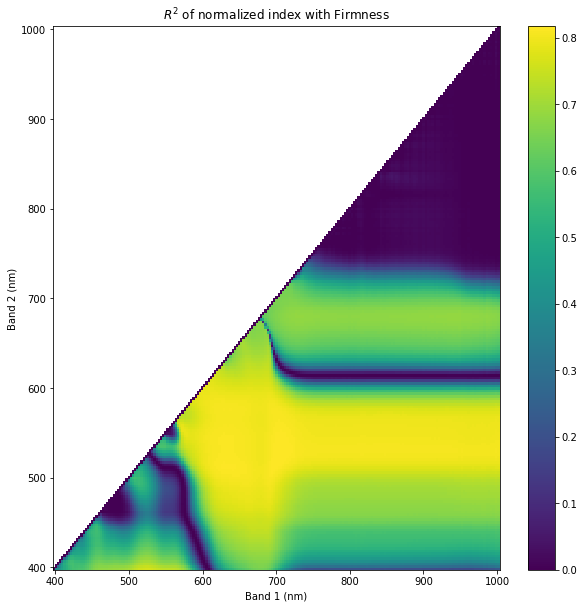

<Figure size 432x288 with 0 Axes>

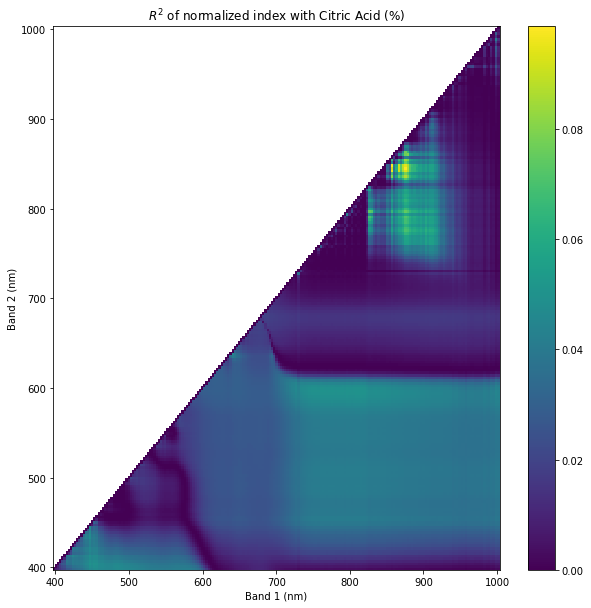

<Figure size 432x288 with 0 Axes>

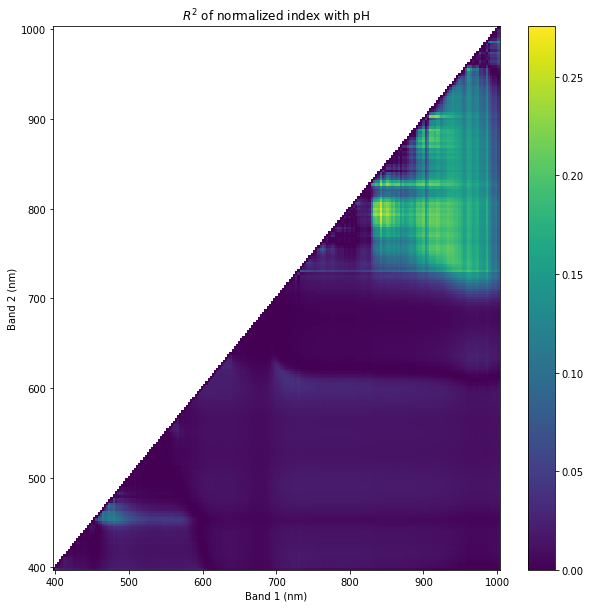

<Figure size 432x288 with 0 Axes>

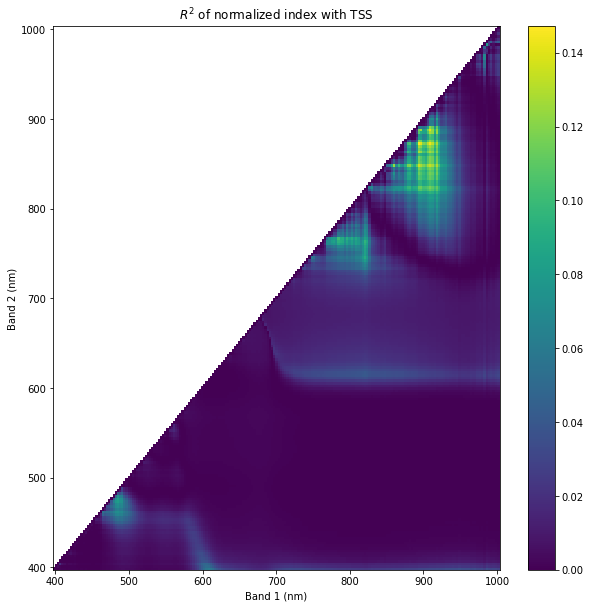

<Figure size 432x288 with 0 Axes>

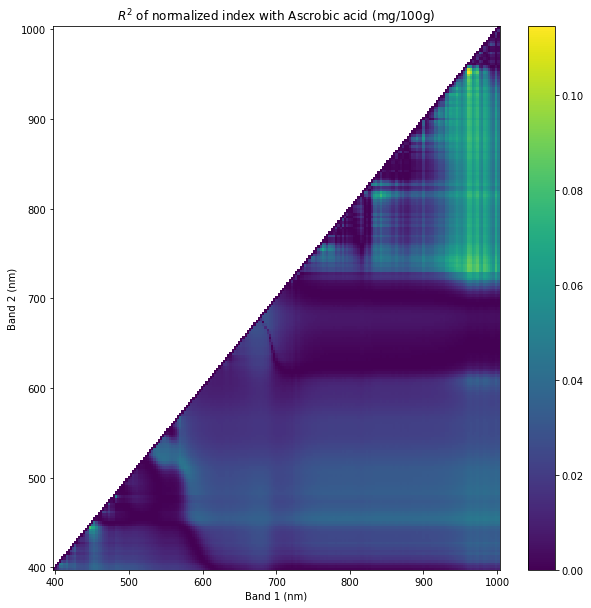

<Figure size 432x288 with 0 Axes>

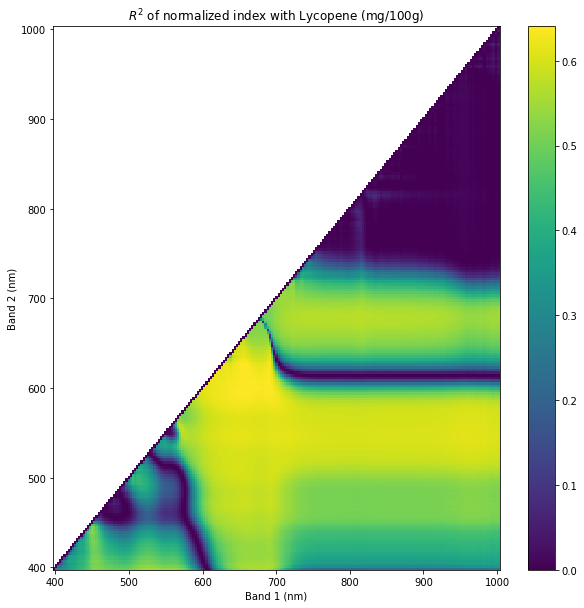

<Figure size 432x288 with 0 Axes>

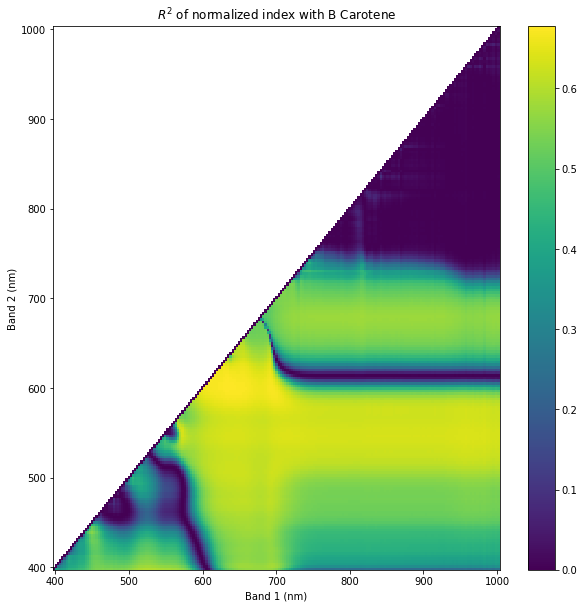

<Figure size 432x288 with 0 Axes>

In [11]:
tomato_list1234.get_color_maps([1])



##$R^2$ colormap for harvests 1,2,3,4

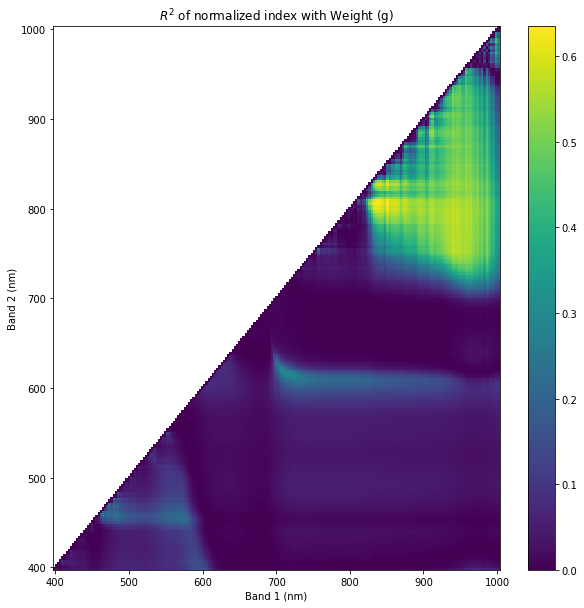

<Figure size 432x288 with 0 Axes>

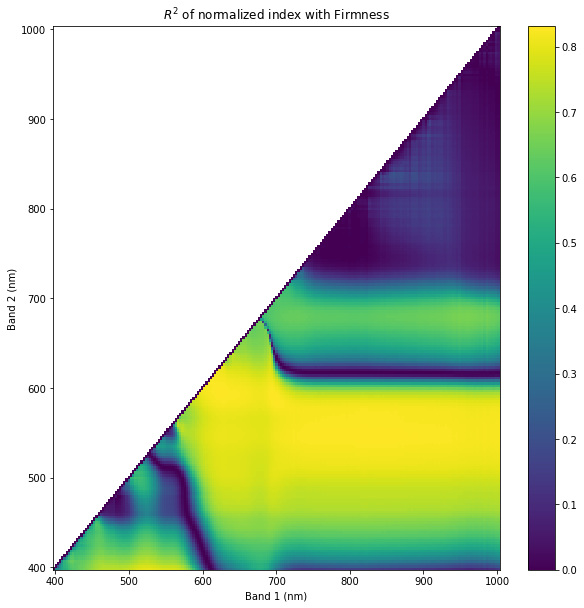

<Figure size 432x288 with 0 Axes>

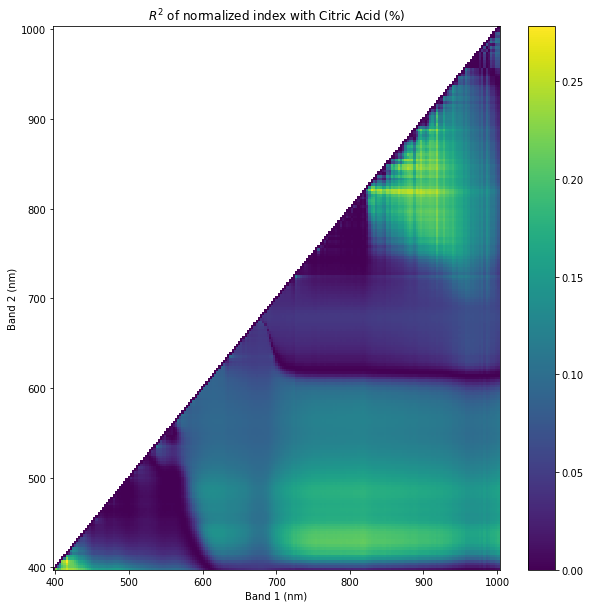

<Figure size 432x288 with 0 Axes>

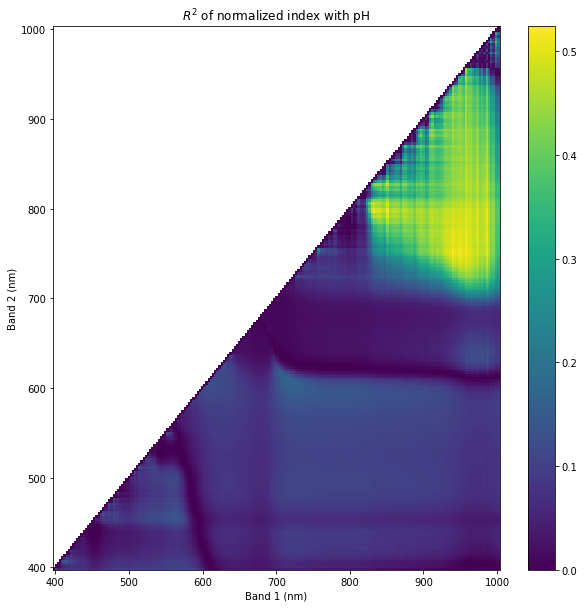

<Figure size 432x288 with 0 Axes>

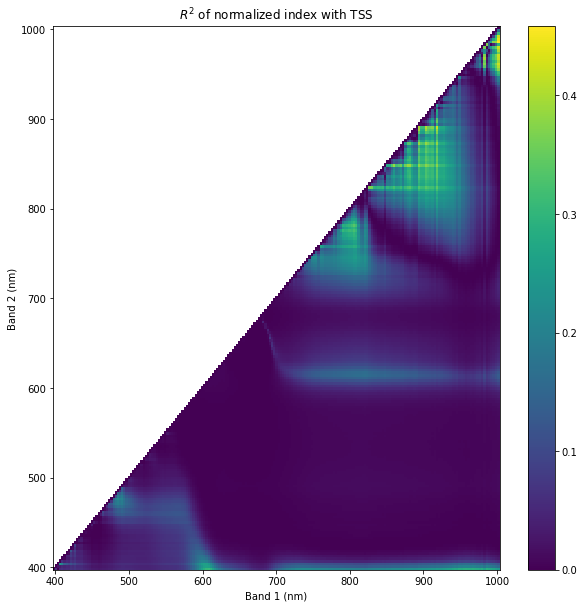

<Figure size 432x288 with 0 Axes>

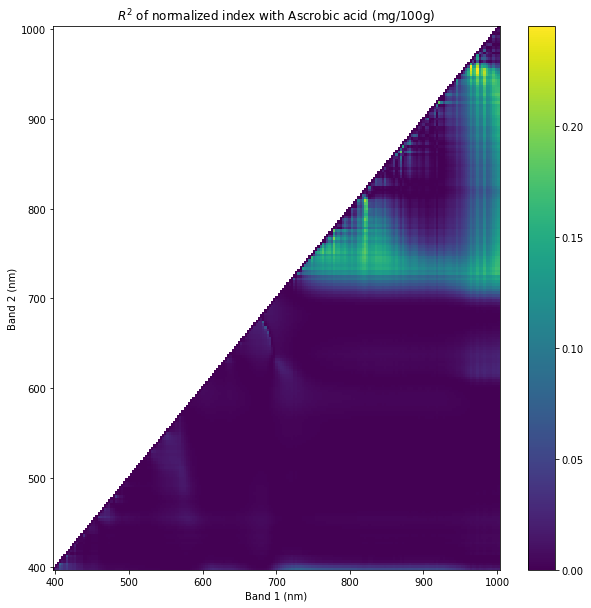

<Figure size 432x288 with 0 Axes>

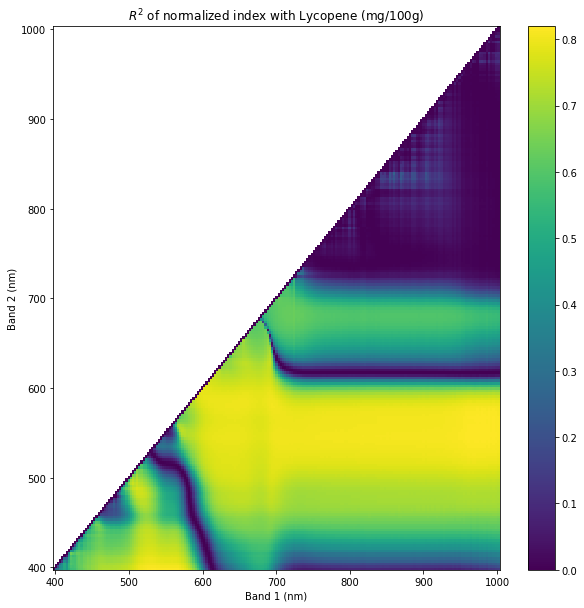

<Figure size 432x288 with 0 Axes>

In [12]:
tomato_list134.get_color_maps([1])

##$R^2$ colormap for harvests 3,4

/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_mstats_common.py:170: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_mstats_common.py:187: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/usr/local/lib/python3.8/dist-packages/scipy/stats/_stats_mstats_common.py:194: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)
/usr/local/lib/python3.8/dist-packages/scipy/stats/stats.py:4484: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


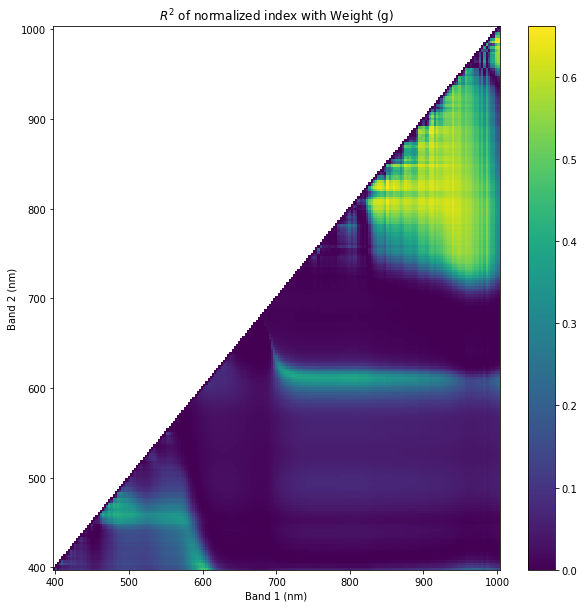

<Figure size 432x288 with 0 Axes>

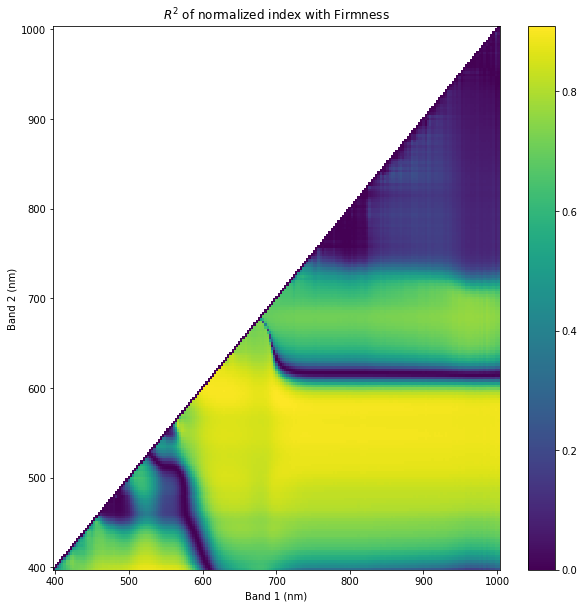

<Figure size 432x288 with 0 Axes>

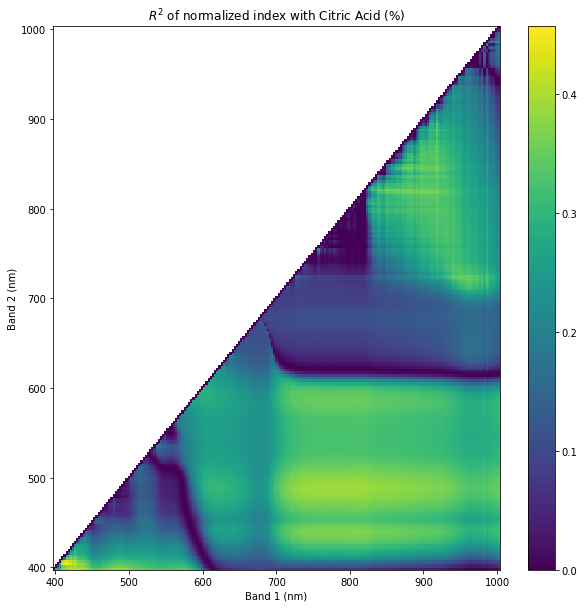

<Figure size 432x288 with 0 Axes>

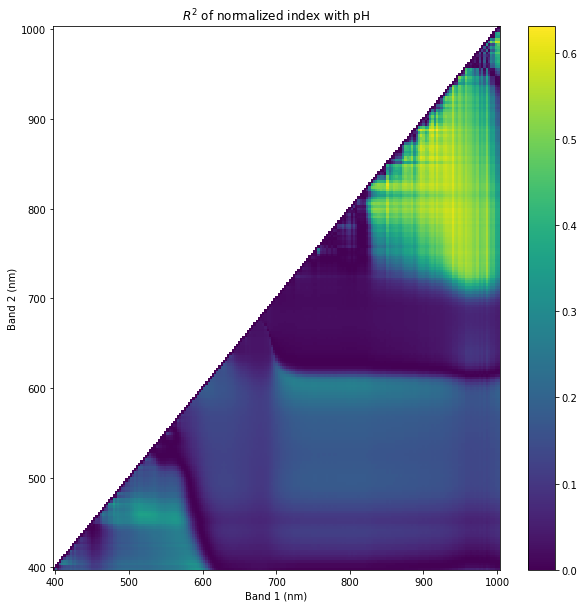

<Figure size 432x288 with 0 Axes>

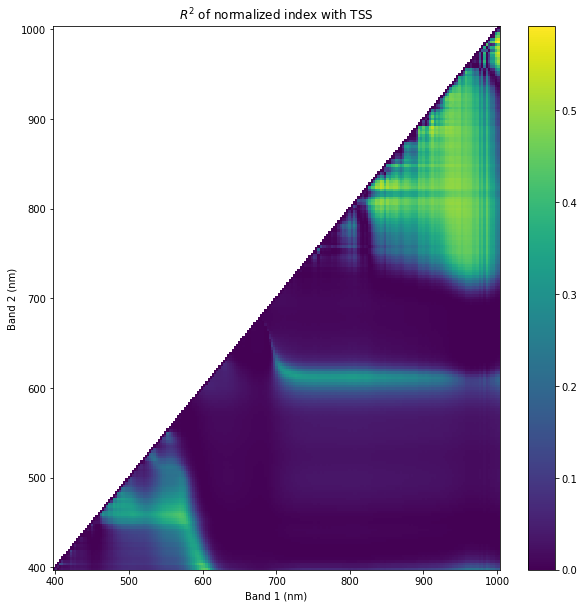

<Figure size 432x288 with 0 Axes>

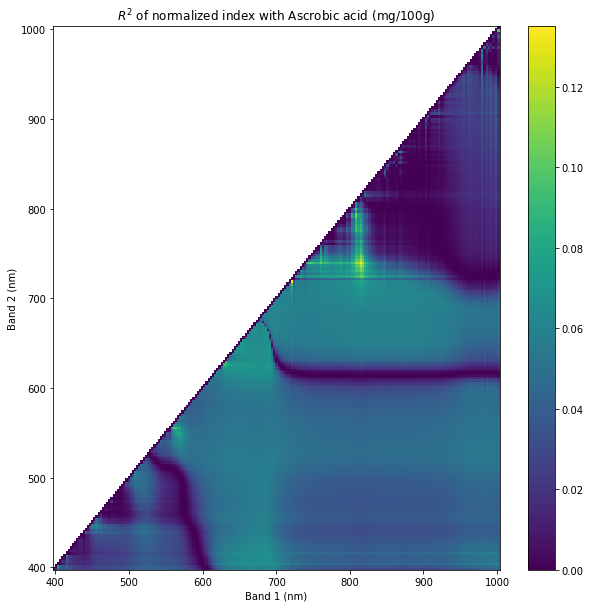

<Figure size 432x288 with 0 Axes>

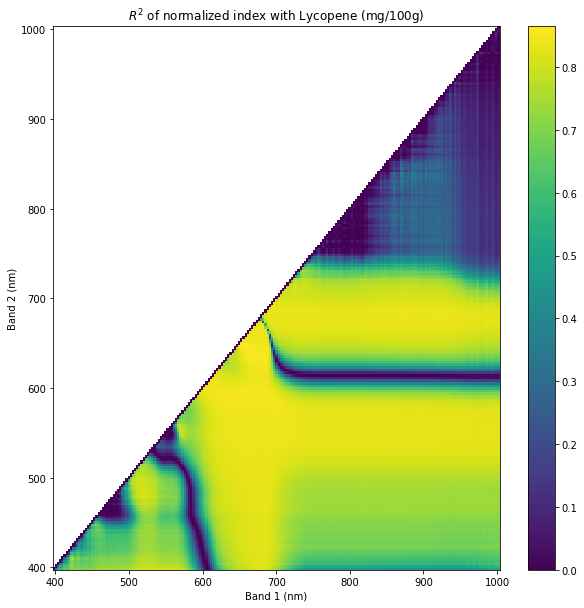

<Figure size 432x288 with 0 Axes>

In [13]:
tomato_list34.get_color_maps([1])


#regretion plots of NI model best fit

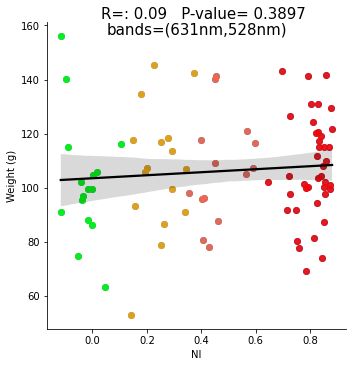

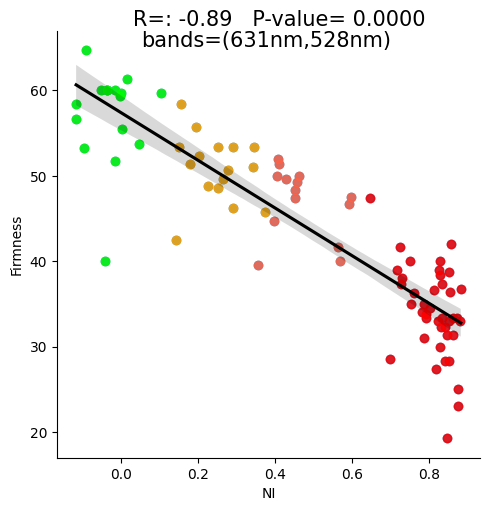

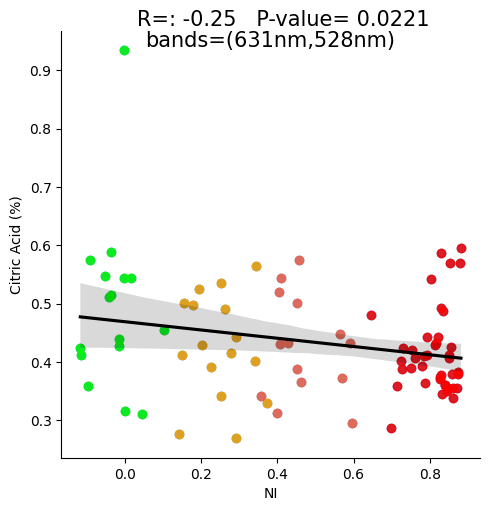

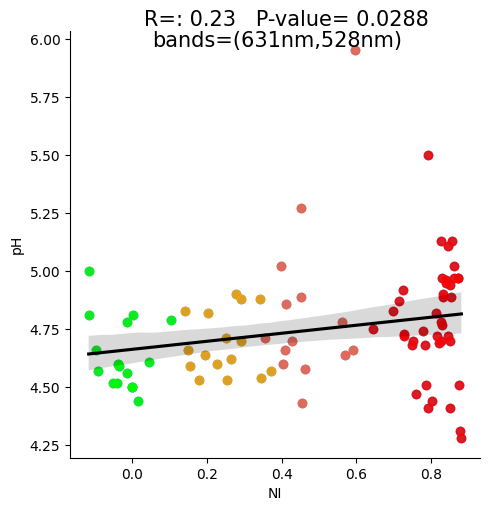

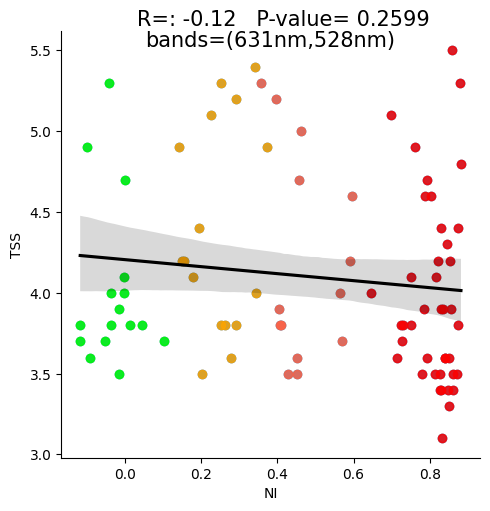

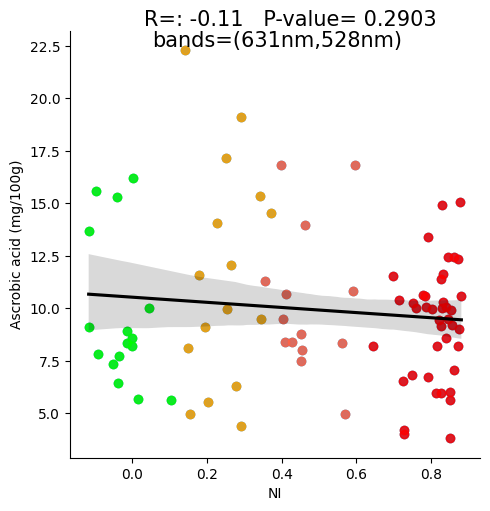

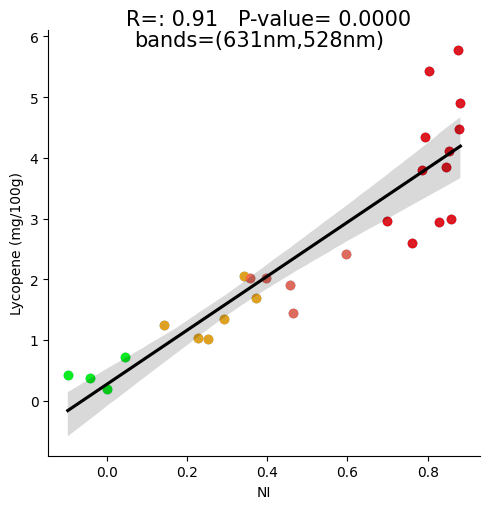

In [ ]:

regretionplot(,)#,r_2)


/usr/local/lib/python3.8/dist-packages/seaborn/axisgrid.py:409: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=figsize)


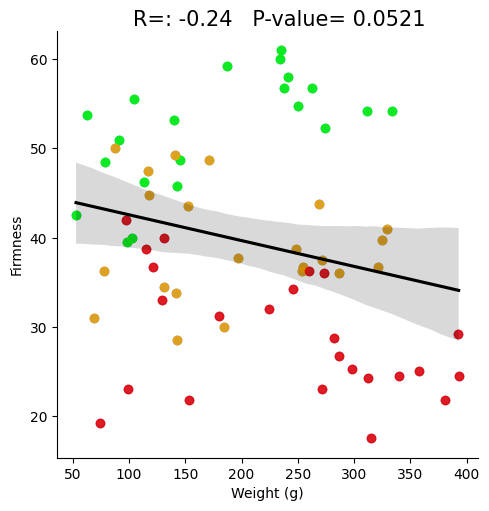

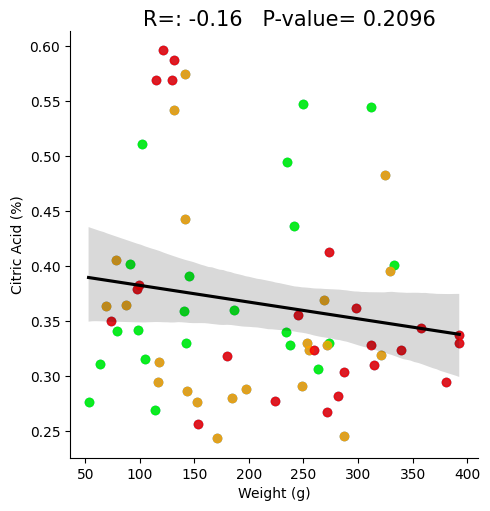

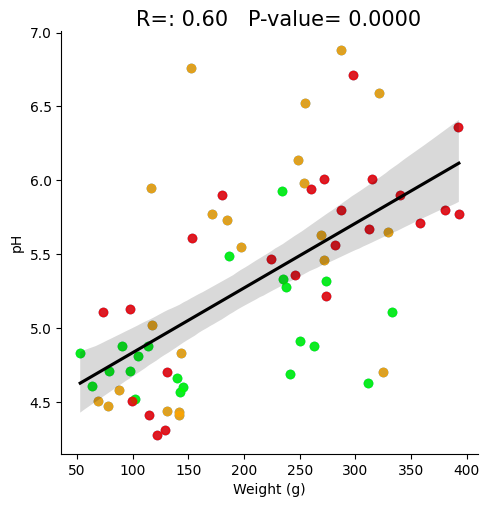

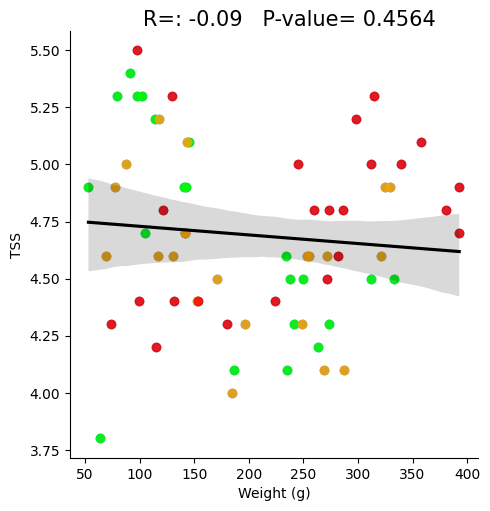

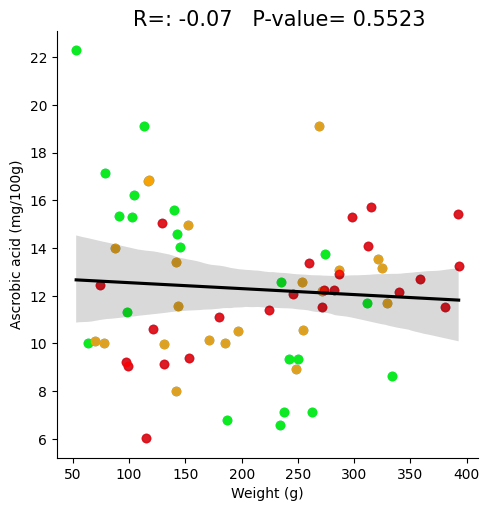

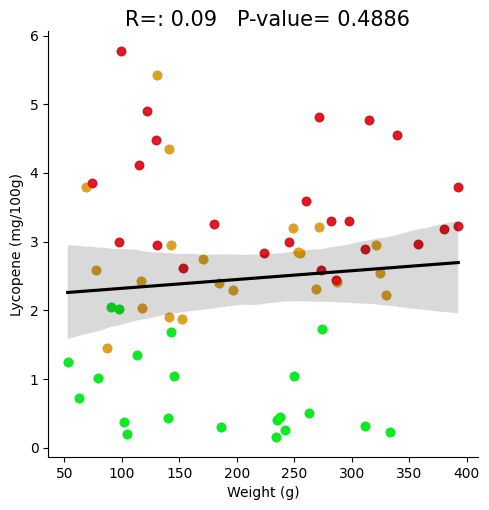

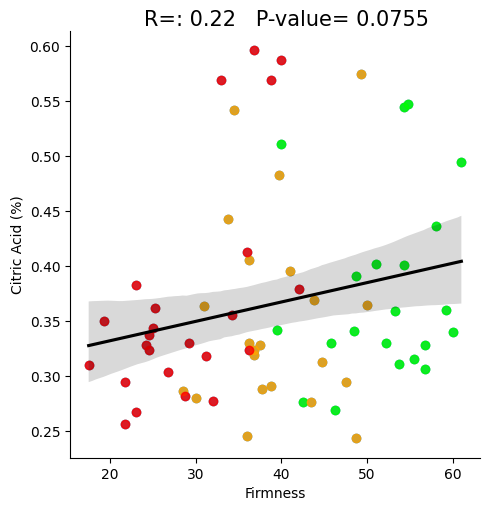

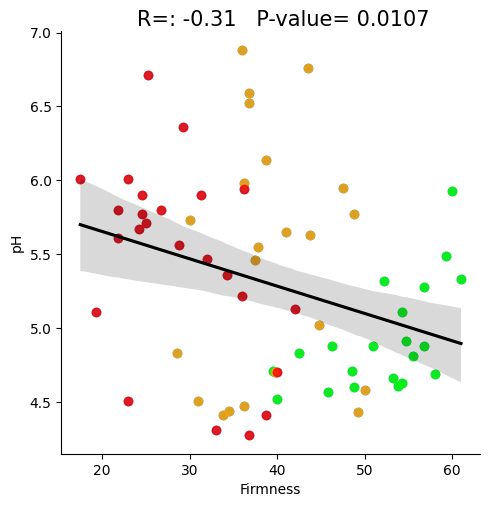

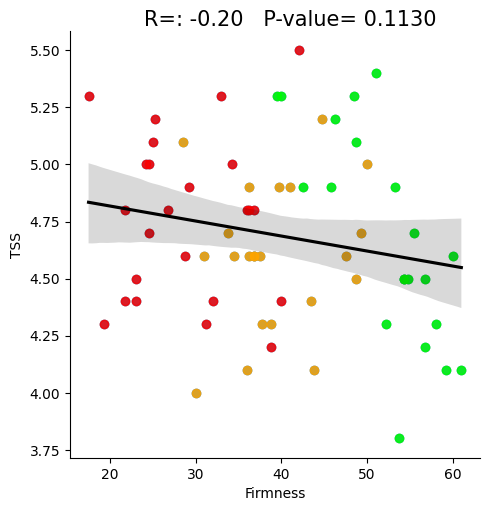

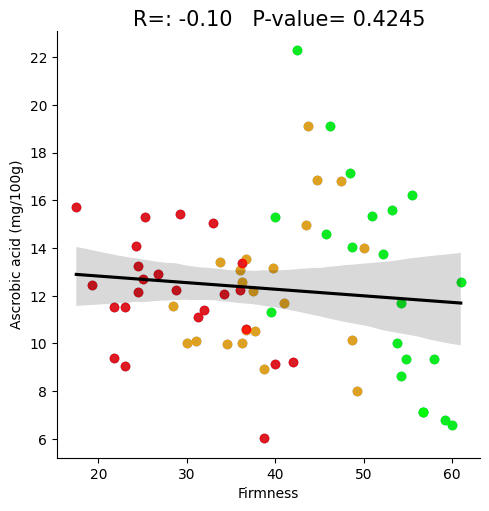

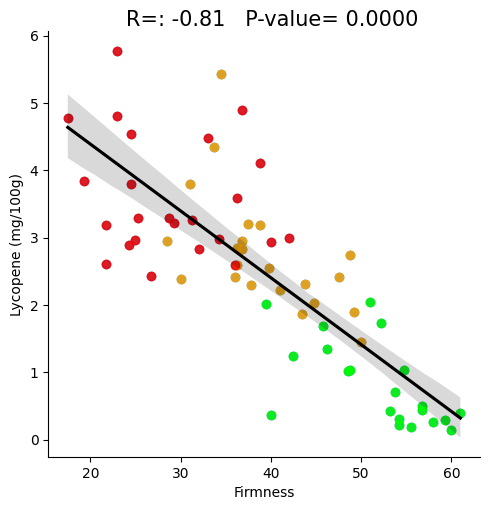

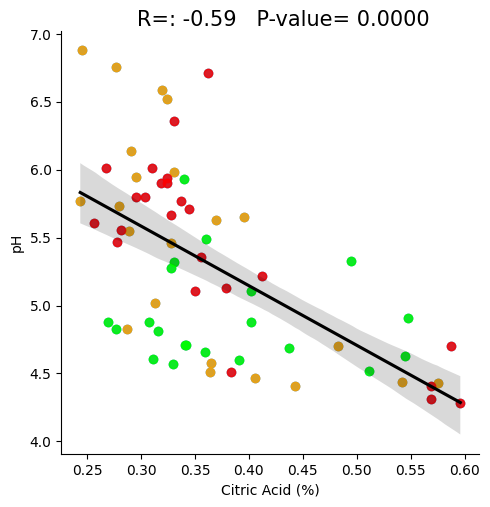

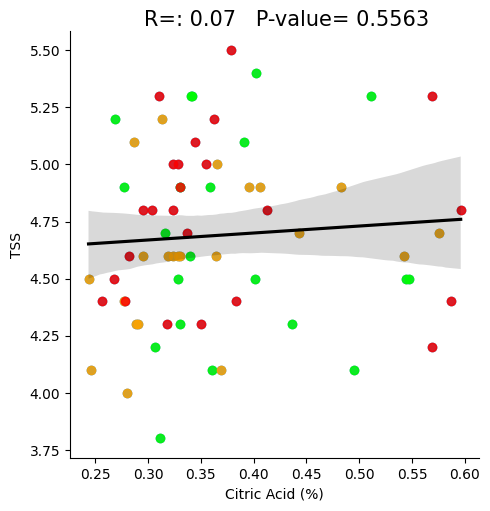

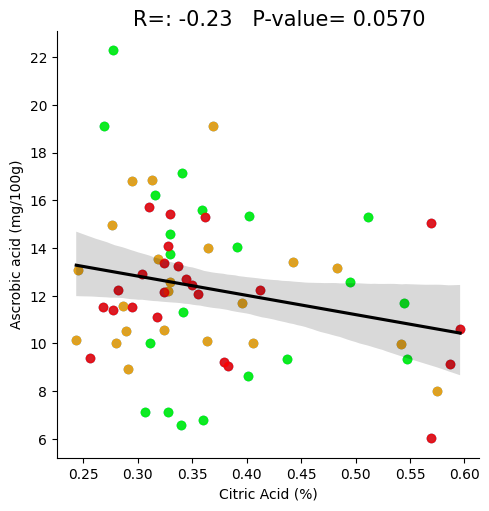

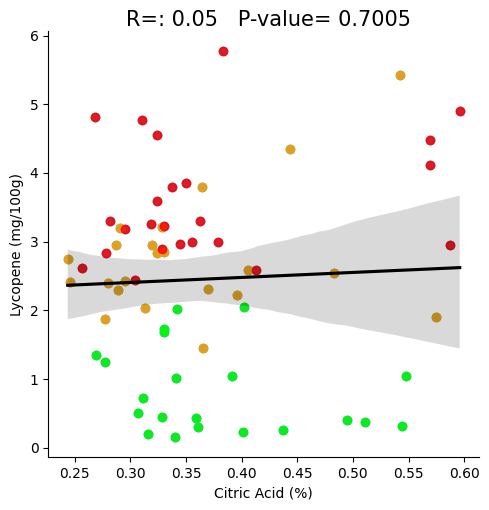

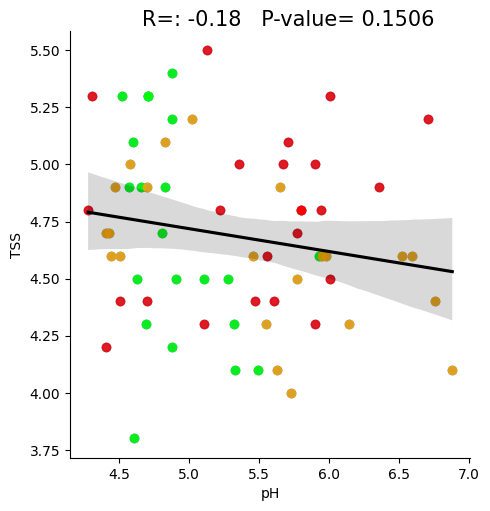

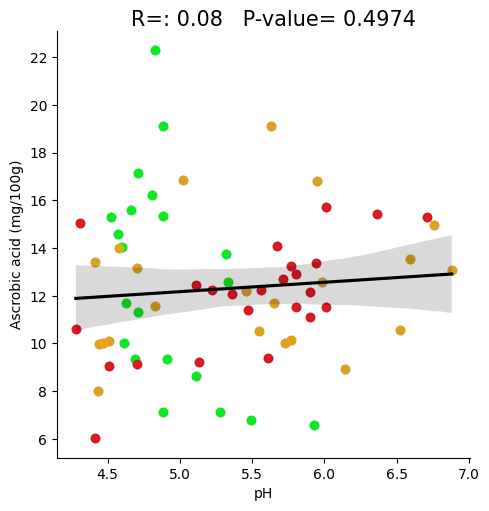

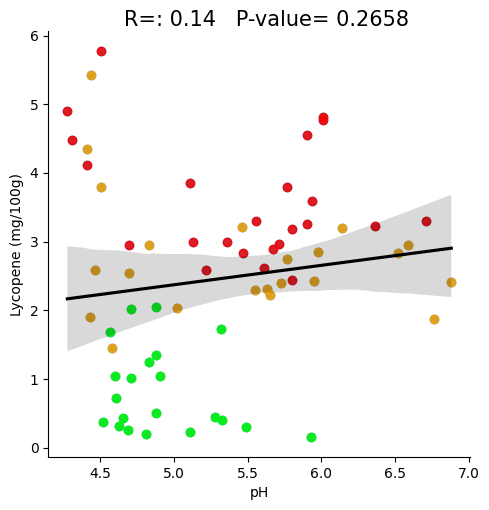

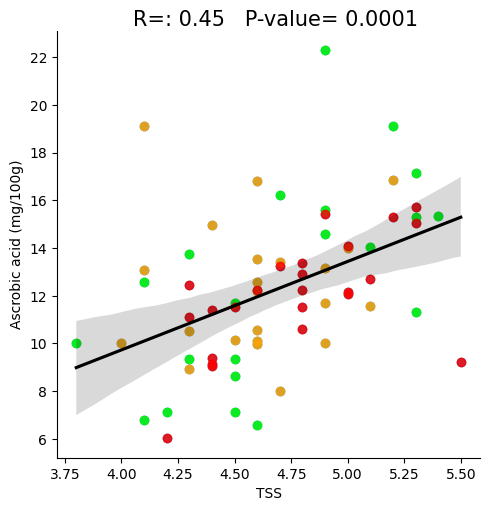

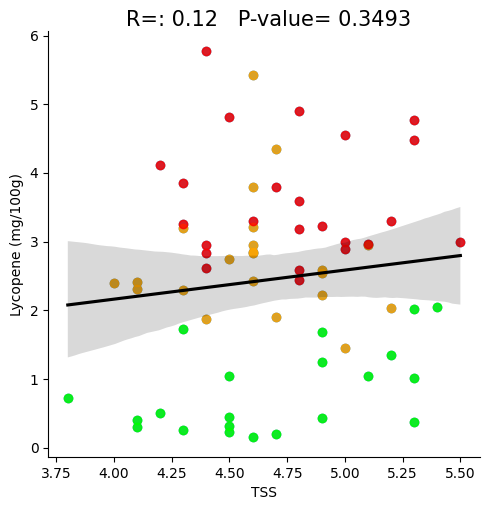

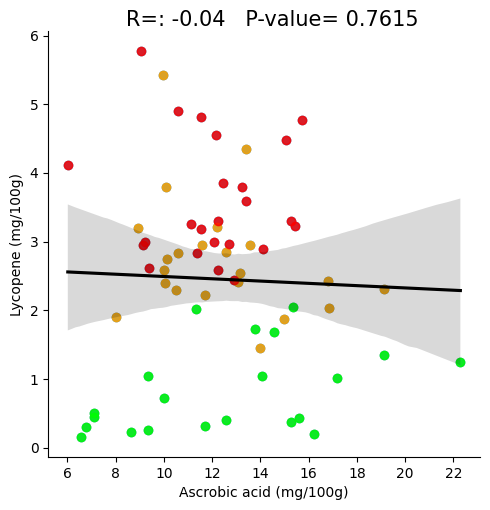

In [31]:
tomato_list=tomato_list1234
# for col1 in tomato_list.lab_results_df.columns:
#   for col2 in tomato_list.lab_results_df.columns:
#     if col1==col2:
#       continue
#     plt.plot(tomato_list.lab_results_df[col1],tomato_list.lab_results_df[col2],'o')
#     plt.show()


show_lab_results_corrolations(tomato_list134)

#PCA

In [ ]:
from sklearn.decomposition import PCA
scaler = MinMaxScaler()
df_normalized=scaler.fit_transform(tomato_list.reflectence_df.T)# - tomato_list.reflectence_df.min()) / (tomato_list.reflectence_df.max()-tomato_list.reflectence_df.min())
pca = PCA(n_components=tomato_list.reflectence_df.shape[1])

# Apply the model
pca.fit(df_normalized)
df_pca = pca.transform(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_,
columns=['PC%s' % _ for _ in range(df_normalized.shape[1])],
index=tomato_list.reflectence_df.columns)

# Graph
fig, ax = plt.subplots(1, figsize=(10,7))
ax.plot(pca.explained_variance_ratio_*100, lw =2,color = "blue")
ax.plot(pca.explained_variance_ratio_*100,'o',lw = 8,color = "black")
ax.set_xlabel(" Components",fontsize=20)
ax.set_ylabel("Explained Variance (%)",fontsize=20)
ax.set_title("PCA",fontsize=25)

In [ ]:
print(f'using 4 bands captures {pca.explained_variance_ratio_[:3].sum()*100:.1f}% of our data varience') 

In [ ]:
scaler=MinMaxScaler()
data_scaled=pd.DataFrame(df_normalized.T)
pca = PCA(n_components=2)
x_new = pca.fit_transform(data_scaled)
data_scaled['color']=None
data_scaled['label']=None
data_scaled.loc[:36,'color']='b'
data_scaled.loc[37:71,'color']='g'
data_scaled.loc[72:104,'color']='r'
data_scaled.loc[105:137,'color']='m'
data_scaled.loc[138:203,'color']='k'

c=data_scaled['color']
c=c.dropna()
l=['400-500nm','500-600nm','600-700nm','700-800nm','800-1000nm']
data_scaled.loc[:36,'label']=l[0]
data_scaled.loc[37:71,'label']=l[1]
data_scaled.loc[72:104,'label']=l[2]
data_scaled.loc[105:137,'label']=l[3]
data_scaled.loc[138:,'label']=l[4]

def myplot(score,coeff,color,legend,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    # plt.scatter(xs * scalex,ys * scaley, c = 'y')
    for i,c,label in zip(range(n),color,legend):
        ax.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        ax.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "b"+str(i+1), color = c, ha = 'center', va = 'center',label=label)

fig = plt.figure(figsize = (7,7))
ax = fig.add_subplot(1,1,1) 
ax.set(xlim=[-0.25,0.25],ylim=[-0.25,0.25])

ax.grid()
legend1={'b':'400-500nm','g':'500-600nm','r':'600-700nm','m':'700-800nm','b':'800-1000nm'}
#Call the function. Use only the 2 PCs.
myplot(x_new[:,0:2],np.transpose(pca.components_[0:2, :]),c,data_scaled['label'][0:204])
ax.legend(legend1)
# ax.title('2 component PCA grid on 204 wavelengths')
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA on 204 bands', fontsize = 20)

np.transpose(pca.components_[0:2, :]).shape

In [ ]:
from sklearn.feature_selection import VarianceThreshold
scaler=MinMaxScaler()
df_normalized=pd.DataFrame(scaler.fit_transform(tomato_list.reflectence_df.T))
sel = VarianceThreshold(threshold=(0.025))
col=[f'b{i}' for i in  range(1,205)]
df_normalized=pd.DataFrame(data=np.array(tomato_list.reflectence_df),columns=col,)
print(sel.fit_transform(df_normalized).shape)
a=sel.get_feature_names_out()
a

#rest of old code

###runing a linear regression model on the data

In [ ]:
def RMSE(y, y_pred):
  """MSE loss of one example"""
  return np.sqrt(((y-y_pred)**2)/(2))
np_ref=np.array(df_ref_scaled.T)
np_firrmness=np.array(df_results['firmness AVG'])
fit_all = linear_model.SGDRegressor() # fit over the entire population
fit_all.fit(np_ref,np_firrmness)
total_err = 0
rmse_train_err = 0
rmse_test_err = 0
rmse_all_err = 0
est_err = 0
iternum=30
for m in range(0,iternum):
  # Randomly sample a training dataset and an unseen (test) sample
  X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=280, test_size=40)
  fit_train = linear_model.SGDRegressor() # fit over the test group
  fit_train.fit(X_train,y_train)
  pred_all = fit_all.predict(X_test)
  pred_train = fit_train.predict(X_train)
  pred_test=fit_train.predict(X_test)
  rmse_train_err += RMSE(y_train,pred_train).mean()
  rmse_test_err += RMSE(y_test,pred_test).mean()
  rmse_all_err += RMSE(y_test,pred_all).mean()

rmse_train_err /= iternum #to get average values
rmse_test_err /= iternum
rmse_all_err /= iternum

print('RMSE train error : ' + '{:.2f}'.format(rmse_train_err))
print('RMSE test error : ' + '{:.2f}'.format(rmse_test_err))
print('RMSE all samples error : ' + '{:.2f}'.format(rmse_all_err))




### Running random forest tree model on the data

In [ ]:

def RMSE(y, y_pred):
  """MSE loss of one example"""
  return np.sqrt(((y-y_pred)**2)/(2))

def add_ref_to_res(ref,res):
  bwr={}#bands with result conected
  length=ref.shape[0]
  new_index=np.arange(0,length)
  ref=ref.set_index(new_index)
  res=res.set_index(new_index)
  for i in res.columns:
    if i=='ID':
      continue
    bwr[i]=pd.concat([ref,res[i]],axis=1)
  return bwr
scaler=MinMaxScaler()
roma_ref_scaled=pd.DataFrame(scaler.fit_transform(roma_ref))
random_forest = RandomForestRegressor()
roma_ref_res=add_ref_to_res(roma_ref_scaled,roma_results)
for i in roma_results.columns:
  # i='% citric acid'
  if i== 'B carotene 'or i=='lycopene':
    continue
  col=roma_ref_res[i].columns
  r=roma_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  fit_all = RandomForestRegressor() # fit over the entire population
  fit_all.fit(np_ref,np_firrmness)
  total_err = 0
  rmse_train_err = 0
  rmse_test_err = 0
  rmse_all_err = 0
  est_err = 0
  iternum=30
  for m in range(0,iternum):
    # Randomly sample a training dataset and an unseen (test) sample
    X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=268, test_size=40)
    fit_train = RandomForestRegressor() # fit over the test group
    fit_train.fit(X_train,y_train)
    pred_all = fit_all.predict(X_test)
    pred_train = fit_train.predict(X_train)
    pred_test=fit_train.predict(X_test)
    rmse_train_err += RMSE(y_train,pred_train).mean()
    rmse_test_err += RMSE(y_test,pred_test).mean()
    rmse_all_err += RMSE(y_test,pred_all).mean()

  rmse_train_err /= iternum #to get average values
  rmse_test_err /= iternum
  rmse_all_err /= iternum
  print(i)
  print('RMSE train error : ' + '{:.2f}'.format(rmse_train_err))
  print('RMSE test error : ' + '{:.2f}'.format(rmse_test_err))
  print('RMSE all samples error : ' + '{:.2f}'.format(rmse_all_err))
  print('R2 train error : ' + '{:.2f}'.format(r2_score(y_train,pred_train)))
  print('R2 test error : ' + '{:.2f}'.format(r2_score(y_test, pred_test)))
  print('R2 all samples error : ' + '{:.2f}'.format(r2_score(y_test,pred_all)))
  plt.plot(y_test, pred_test,'o')
  plt.show()

In [ ]:
 scaler=MinMaxScaler()
soli_ref_scaled=pd.DataFrame(scaler.fit_transform(soli_ref))
random_forest = RandomForestRegressor()
soli_ref_res=add_ref_to_res(soli_ref_scaled,soli_results)
for i in soli_results.columns[2:]:
  i= '% citric acid'
  if i== 'B carotene ':
    continue
  col=soli_ref_res[i].columns
  r=soli_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  fit_all = RandomForestRegressor() # fit over the entire population
  fit_all.fit(np_ref,np_firrmness)
  total_err = 0
  rmse_train_err = 0
  rmse_test_err = 0
  rmse_all_err = 0
  est_err = 0
  iternum=30
  for m in range(0,iternum):
    # Randomly sample a training dataset and an unseen (test) sample
    X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=30, test_size=10)
    fit_train = RandomForestRegressor() # fit over the test group
    fit_train.fit(X_train,y_train)
    pred_all = fit_all.predict(X_test)
    pred_train = fit_train.predict(X_train)
    pred_test=fit_train.predict(X_test)
    rmse_train_err += RMSE(y_train,pred_train).mean()
    rmse_test_err += RMSE(y_test,pred_test).mean()
    rmse_all_err += RMSE(y_test,pred_all).mean()

  rmse_train_err /= iternum #to get average values
  rmse_test_err /= iternum
  rmse_all_err /= iternum
  print(i)
  print('RMSE train error : ' + '{:.2f}'.format(rmse_train_err))
  print('RMSE test error : ' + '{:.2f}'.format(rmse_test_err))
  print('RMSE all samples error : ' + '{:.2f}'.format(rmse_all_err))
  print('R2 train error : ' + '{:.2f}'.format(r2_score(y_train,pred_train)))
  print('R2 test error : ' + '{:.2f}'.format(r2_score(y_test, pred_test)))
  print('R2 all samples error : ' + '{:.2f}'.format(r2_score(y_test,pred_all)))
  plt.plot(y_test, pred_test,'o')
  plt.show()

In [ ]:
scaler=MinMaxScaler()
united_ref_scaled=pd.DataFrame(scaler.fit_transform(united_ref))
random_forest = RandomForestRegressor()
united_ref_res=add_ref_to_res(united_ref_scaled,united_results)
for i in soli_results.columns[1:]:
  
  if i== 'B carotene 'or i =='lycopene':
    continue
  col=united_ref_res[i].columns
  r=united_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  fit_all = RandomForestRegressor() # fit over the entire population
  fit_all.fit(np_ref,np_firrmness)
  total_err = 0
  rmse_train_err = 0
  rmse_test_err = 0
  rmse_all_err = 0
  est_err = 0
  iternum=30
  for m in range(0,iternum):
    # Randomly sample a training dataset and an unseen (test) sample
    X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=280, test_size=40)
    fit_train = RandomForestRegressor() # fit over the test group
    fit_train.fit(X_train,y_train)
    pred_all = fit_all.predict(X_test)
    pred_train = fit_train.predict(X_train)
    pred_test=fit_train.predict(X_test)
    rmse_train_err += RMSE(y_train,pred_train).mean()
    rmse_test_err += RMSE(y_test,pred_test).mean()
    rmse_all_err += RMSE(y_test,pred_all).mean()

  rmse_train_err /= iternum #to get average values
  rmse_test_err /= iternum
  rmse_all_err /= iternum
  print(i)
  print('RMSE train error : ' + '{:.2f}'.format(rmse_train_err))
  print('RMSE test error : ' + '{:.2f}'.format(rmse_test_err))
  print('RMSE all samples error : ' + '{:.2f}'.format(rmse_all_err))
  print('R2 train error : ' + '{:.2f}'.format(r2_score(y_train,pred_train)))
  print('R2 test error : ' + '{:.2f}'.format(r2_score(y_test, pred_test)))
  print('R2 all samples error : ' + '{:.2f}'.format(r2_score(y_test,pred_all)))
  plt.plot(y_test, pred_test,'o')
  plt.show()

In [ ]:
class Tomatoes:
  def __init__(self):
    root_data_path='/content/drive/MyDrive/Shared_tomato/Eitan/ROMA_AS200_13_10_2021/SPECTRAL_DATA/Reflectence_ID1_320.csv'
    root_result_path='/content/drive/MyDrive/Shared_tomato/Eitan/ROMA_AS200_13_10_2021/VOLCANI_CENTER/CHEMICAL _RESULTS_ROMA_AS_200_13_10_2021_ID_1_320.csv'
    df_ref=  pd.read_csv(root_data_path) 
    col=df_ref.columns
    scaler = MinMaxScaler()
    df_ref=df_ref.drop([col[0]], axis=1)
    df_ref_scaled=np.array(scaler.fit_transform(df_ref))
    df_results=  pd.read_csv(root_result_path)  
    df_results=df_results.drop(['ID'],axis=1)
    scaler = MinMaxScaler()
    x=np.array(df_ref_scaled).T
    # x = df_ref.values
    y=df_results['firmness AVG'].values
    self.x=torch.tensor(x,dtype=torch.float32)
    self.y=torch.tensor(y,dtype=torch.float32)
    

  def __getitem__(self,index): 
    ref = self.x[index, :]
    result = self.y[index]
    return ref, result
       
  def __len__(self): 
    return len(self.y)

In [ ]:
device = (torch.device('cuda') if torch.cuda.is_available()
  else torch.device('cpu'))
print(f"Training on device {device}.")


In [ ]:
T=Tomatoes()
index=random.randint(0,T.__len__())
tomato, label=T.__getitem__(index)
plt.plot(range(0,204),tomato)
plt.title(f'Tomato {index}')
plt.ylabel('Reflectence')
plt.xlabel('channel')
print(f'firmness is {label} (N)')

In [ ]:
batch_size = 30

In [ ]:
train_validation_split = 0.70 
validation_test_split = 0.85 
shuffle_dataset = True
random_seed = None # Make this None to have a different shuffling each run

# Creating random data indices for training, validation and testing splits:
dataset_size =T.__len__()
indices = list(range(dataset_size))
split_val = int(np.floor(train_validation_split * dataset_size))
split_test = int(np.floor(validation_test_split * dataset_size))
if shuffle_dataset:
  if random_seed is not None:
    np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices, test_indices = indices[:split_val], indices[split_val:split_test], indices[split_test:]

# Creating data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(T, batch_size=batch_size,
                                          sampler=train_sampler, pin_memory=True,drop_last=True)
validation_loader = torch.utils.data.DataLoader(T, batch_size=batch_size,
                                          sampler=valid_sampler, pin_memory=True,drop_last=True)
test_loader = torch.utils.data.DataLoader(T, batch_size=batch_size, 
                                          sampler=test_sampler, pin_memory=True,drop_last=True)


In [ ]:
class TomatoNet(nn.Module):
   def __init__(self):
        super(TomatoNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(204,102),
            nn.ReLU(),
            nn.Linear(102, 51),
            nn.ReLU(),
            nn.Linear(51, 1),
        )

   def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits  

In [ ]:
model = TomatoNet().to(device)
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

In [ ]:

def plot_acc_loss(model_history,title):
  plt.figure(figsize=(15, 5))
  #model_history= [train_loss_history, train_accuracy_history, val_loss_history, val_accuracy_history]
  # plt.subplot(1,2,1)
  plt.plot(model_history[0],'b', label='Train')
  plt.plot(model_history[1],'r', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('CrossEntropy loss')
  plt.legend()
  best_val_loss = np.min(model_history[1])
  best_val_loss_i = np.argmin(model_history[1])
  plt.scatter(best_val_loss_i, best_val_loss, color='green', s=150, marker='X', zorder=3)
  plt.text(best_val_loss_i, best_val_loss, '\nBest validation\nloss: {:.3f}'.format(best_val_loss), va='top')
  # plt.subplot(1,2,2)
  # plt.plot(model_history[1],'b', label='Train')
  # plt.plot(model_history[3],'r', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('RMSE')
  plt.legend()
  plt.title(title)
  plt.show()


In [ ]:
pip install skorch

In [ ]:
from skorch import NeuralNetRegressor
from torch import optim
from sklearn.metrics import mean_squared_error
scaler=MinMaxScaler()
united_ref_scaled=pd.DataFrame(scaler.fit_transform(united_ref))
random_forest = RandomForestRegressor()
united_ref_res=add_ref_to_res(united_ref_scaled,united_results)
for i in soli_results.columns[1:]:
  i='pH'
  if i== 'B carotene 'or i =='lycopene':
    continue
  col=united_ref_res[i].columns
  r=united_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=300, test_size=50)
  learning_rate=0.001
  y_train = y_train.reshape(-1, 1)
  y_train=y_train.astype(np.float32)
  X_train=X_train.astype(np.float32)
  X_test=X_test.astype(np.float32)
  skorch_regressor = NeuralNetRegressor(module=TomatoNet, optimizer=optim.Adam, max_epochs=300,lr=learning_rate,verbose=0, batch_size=16)
  skorch_regressor.fit(X_train,y_train)
  Y_preds = skorch_regressor.predict(X_test)

  print(i)
  print("Train RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
  print("Test  RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

  print("\nTrain R^2 : {:.3f}".format(skorch_regressor.score(X_train, y_train)))
  print("Test  R^2 : {:.3f}".format(skorch_regressor.score(X_test, y_test)))


In [ ]:
from skorch import NeuralNetRegressor
from torch import optim
from sklearn.metrics import mean_squared_error
scaler=MinMaxScaler()
roma_ref_scaled=pd.DataFrame(scaler.fit_transform(roma_ref))
random_forest = RandomForestRegressor()
roma_ref_res=add_ref_to_res(roma_ref_scaled,roma_results)
for i in soli_results.columns[1:]:
  i ='lycopene'
  if i== 'B carotene ':
    continue
  col=united_ref_res[i].columns
  r=roma_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=268, test_size=40)
  learning_rate=0.001
  y_train = y_train.reshape(-1, 1)
  y_train=y_train.astype(np.float32)
  X_train=X_train.astype(np.float32)
  X_test=X_test.astype(np.float32)
  skorch_regressor = NeuralNetRegressor(module=TomatoNet, optimizer=optim.Adam, max_epochs=300,lr=learning_rate,verbose=0, batch_size=16)
  skorch_regressor.fit(X_train,y_train)
  Y_preds = skorch_regressor.predict(X_test)

  print(i)
  # print("Train RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
  print("Test  RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

  # print("\nTrain R^2 : {:.3f}".format(skorch_regressor.score(X_train, y_train)))
  print("Test  R^2 : {:.3f}".format(skorch_regressor.score(X_test, y_test)))


In [ ]:
from skorch import NeuralNetRegressor
from torch import optim
from sklearn.metrics import mean_squared_error
scaler=MinMaxScaler()
soli_ref_scaled=pd.DataFrame(scaler.fit_transform(soli_ref))
random_forest = RandomForestRegressor()
soli_ref_res=add_ref_to_res(soli_ref_scaled,soli_results)
for i in soli_results.columns[1:]:
  
  if i== 'B carotene ':
    continue
  col=soli_ref_res[i].columns
  r=soli_ref_res[i]
  indexNames = r[ r[col[-1]] <0.1 ].index
  r.drop(indexNames , inplace=True)
  np_firrmness=np.array(r[col[-1]].dropna())
  np_ref=np.array(r[col[0:-1]].dropna())

  X_train, X_test, y_train, y_test = train_test_split(np_ref,np_firrmness, train_size=25, test_size=15)
  learning_rate=0.001
  y_train = y_train.reshape(-1, 1)
  y_train=y_train.astype(np.float32)
  X_train=X_train.astype(np.float32)
  X_test=X_test.astype(np.float32)
  skorch_regressor = NeuralNetRegressor(module=TomatoNet, optimizer=optim.Adam, max_epochs=300,lr=learning_rate,verbose=0, batch_size=16)
  skorch_regressor.fit(X_train,y_train)
  Y_preds = skorch_regressor.predict(X_test)

  print(i)
  # print("Train RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
  print("Test  RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

  # print("\nTrain R^2 : {:.3f}".format(skorch_regressor.score(X_train, y_train)))
  print("Test  R^2 : {:.3f}".format(skorch_regressor.score(X_test, y_test)))


In [ ]:
Y_preds = skorch_regressor.predict(X_test)
from sklearn.metrics import mean_squared_error

print("Train RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
print("Test  RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

print("\nTrain R^2 : {:.3f}".format(skorch_regressor.score(X_train, y_train)))
print("Test  R^2 : {:.3f}".format(skorch_regressor.score(X_test, y_test)))

In [ ]:
model_history=skorch_regressor.history[:, ("train_loss", "valid_loss")]
model_history_train=[np.sqrt(i[0]) for i in model_history]
model_history_val=[np.sqrt(i[1]) for i in model_history]
model_history=[model_history_train,model_history_val]
title=f'NN epochs='#{epoch_num}, batch size={batch_size}, lr={learning_rate}, hidden lyers=3, optimizer= Adam'
plot_acc_loss(model_history,title)


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    "lr": [0.01, 0.02,0.5,0.005],
    "max_epochs": [100, 250, 500],
}

grid = GridSearchCV(skorch_regressor, params)

grid.fit(X_train, y_train)

In [ ]:
print("Best Score  : {}".format(grid.best_score_))
print("Best Params : {}".format(grid.best_params_))

In [ ]:
learning_rate=0.02
skorch_regressor = NeuralNetRegressor(module=TomatoNet, optimizer=optim.Adam, max_epochs=500,lr=learning_rate,verbose=0, batch_size=16)
skorch_regressor.fit(X_train,y_train)
params = {
    "optimizer__weight_decay": [0, 0.1,0.2,0.3],
    "optimizer": [optim.Adam,optim.SGD],
    "batch_size":[8,16,32]

}

grid = GridSearchCV(skorch_regressor, params)

grid.fit(X_train, y_train)

In [ ]:
print("Best Score  : {}".format(grid.best_score_))
print("Best Params : {}".format(grid.best_params_))

In [ ]:
learning_rate=0.002
skorch_regressor = NeuralNetRegressor(module=TomatoNet, optimizer=optim.Adam, max_epochs=500,lr=learning_rate,verbose=0, batch_size=8)
skorch_regressor.fit(X_train,y_train)
Y_preds = skorch_regressor.predict(X_test)
print("Train RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
print("Test  RMSE : {:.2f}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

print("\nTrain R^2 : {:.3f}".format(skorch_regressor.score(X_train, y_train)))
print("Test  R^2 : {:.3f}".format(skorch_regressor.score(X_test, y_test)))
model_history=skorch_regressor.history[:, ("train_loss", "valid_loss")]
model_history_train=[np.sqrt(i[0]) for i in model_history]
model_history_val=[np.sqrt(i[1]) for i in model_history]
model_history=[model_history_train,model_history_val]
title=f'NN epochs={500}, batch size={8}, lr={0.02}, hidden lyers=3, optimizer= Adam'
plot_acc_loss(model_history,title)


In [ ]:
class TomatoNetCNN(nn.Module):
   def __init__(self):
        super(TomatoNetCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_layers = nn.Sequential(
            nn.Conv1d(in_channels=14,out_channels=204, kernel_size=60, stride=1,padding=20),
            nn.ReLU(),
            nn.Conv1d(in_channels=204,out_channels=408, kernel_size=30, stride=1,padding=20),
            nn.ReLU(),
            nn.Conv1d(in_channels=408,out_channels=204, kernel_size=15, stride=1,padding=20),
            nn.ReLU(),
            nn.Conv1d(in_channels=204,out_channels=14, kernel_size=5, stride=1,padding=20),
            
            )
        self.pool_layer = nn.MaxPool1d(kernel_size=2, stride=1)
        self.other_layers=nn.Sequential(
            nn.Linear(257,140),
            nn.ReLU(),
            nn.Linear(140,14))
   def forward(self, x):
        
        # x=self.pool_layer(x)
        # print(x.shape)
        x=self.conv_layers(x)
        x=self.flatten(x)
        # print(x.shape)
        x=self.pool_layer(x)
        # print(x.shape)
        x=self.flatten(x)
        # print(x.shape)
        x=self.other_layers(x)
        # print(x.shape,'done')
        return x  

In [ ]:
model = TomatoNetCNN().to(device)
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()}")

In [ ]:
learning_rate=0.001
batch_size=14
skorch_regressor = NeuralNetRegressor(module=TomatoNetCNN, optimizer=optim.Adam, max_epochs=300, verbose=0,lr=learning_rate,batch_size=batch_size)
skorch_regressor.fit(X_train,y_train)


In [ ]:
Y_preds = skorch_regressor.predict(X_test)

print("Train MSE : {}".format(np.sqrt(mean_squared_error(y_train, skorch_regressor.predict(X_train).reshape(-1)))))
print("Test  MSE : {}".format(np.sqrt(mean_squared_error(y_test, skorch_regressor.predict(X_test).reshape(-1)))))

print("\nTrain R^2 : {}".format(skorch_regressor.score(X_train, y_train)))
print("Test  R^2 : {}".format(skorch_regressor.score(X_test, y_test)))

In [ ]:
model_history=skorch_regressor.history[:, ("train_loss", "valid_loss")]
model_history_train=[np.sqrt(i[0]) for i in model_history]
model_history_val=[np.sqrt(i[1]) for i in model_history]
model_history=[model_history_train,model_history_val]
title=f'NN epochs={500}, batch size={8}, lr={0.02}, hidden lyers=3, optimizer= Adam'
plot_acc_loss(model_history,title)
